# Is there difficulty variation between degrees at LSE?


## Table of Contents


 **Introduction**

* 1.1	Motivation
* 1.2	Objectives and Research Questions
* 1.3	Originality
* 1.4	Brief Overview of Project Process

**Data Acquisition and Preparation**
* 2.1	Degree Data Scraping
* 2.2	Module Grade Distributions Scraping
* 2.3	Modules Extra Information Scraping

**Degree Data Preparation and Analysis**
* 3.1.	Degree Data Exploration and Wrangling
* 3.2.	Degree Data Analysis and Visualisation

 **Module Data Preparation**
* 4.1.	Why did we choose these degrees
* 4.2.	The general method employed
* 4.3.	Discovering the Designs
   * 4.31) Finance
   * 4.32) Economics
   * 4.33) International Relations
   * 4.34) Politics and Economics
   * 4.35) Physchological and Behavioural Sciences

 **Module-wide Analysis**
<br>

 **Summary and Conclusion**
* 6.1.	Summary of findings
* 6.2.	Conclusions based on findings
* 6.3.	Potential analysis limitations
* 6.4.	References


# 1. Introduction

## Motivation

As undergraduate students who have recently undergone the UCAS application process, we aim to verify whether studying a specific degree offers a higher chance of achieving higher grades and, subsequently, a higher graduate salary compared to studying another degree. Finally, we are examining the discrepancy of grade distribution within each degree, varying for different combinations of optional modules.

## Overview of Project Process


This introductory-level study will include creating a data frame, which allows for possible module combinations that a student can take within a degree. This will be restricted to the recommended modules, under which we will then work out grade distributions by module. Module selection will be based on specific criteria of interest that are thoroughly explained through the analysis. 

Following the module selection, we will conduct a hypothesis test, by accounting for the standard error within each module, to see if it is statistically possible to artificially 
increase your chances of receiving higher degree marks, and if this leads to accessing the increased rewards of higher graduation grades.

Finally, we will examine on a quantitative and/or qualitative note different statistics that could play a part in each module and degree grade attainment. 


## Originality

Looking at LSE’s freedom of information page as well as any other publicly available data, there is no similar database or study that has been done, looking at the possible commutations accounting for standard errors to produce a statistical test on this data. This is the primary aspect which we consider to be original.

## Research Questions

* Is it possible to ‘game the system’ in terms of degree choice and module choice to unlock greater graduation outcomes?
* Does the grade attainment difference between the “hard” and “easy” degree designs depend on optionality, application acceptance rate, and/or graduation salary?


# 2. Data Sourcing

To effectively address our research question — how undergraduate students at LSE might strategically select courses and degrees that offer relatively easier pathways to achieving high grades — we first need to acquire a range of publicly available data from LSE's online resources. This initial phase involves identifying relevant data sources, scraping and collecting data, exploring and cleaning said datasets from faulty and irrelevant information, as well as preparing and structuring the datasets for downstream processing and analysis.

The data sourcing process was divided into collecting two core datasets: (1) degree programme data, including recommended modules and application statistics, and (2) grade distributions by module, obtained from 5-year departmental PDF reports. These datasets need to be collected through targeted web scraping and manual extraction methods, considering the limitations of unstructured or semi-structured web formats.


### Data of interest
We specifically focused on the following data elements:
1. **Undergraduate Degrees 2024/25:**
    * Degree Names (of all available programmes)
    * Module Information
        * Mandatory Modules (per year)
        * Outside Module Options
    * Extra Information
        * A-level requirements
        * Application stats (volume, intake & acceptance rate)
        * Tuition fees
        * Median salary post-graduation
<br>
<br>
2. **Undergraduate Modules 2024/25:**
    * Module Codes (of all available courses)
    * Grade distributions
        * Grade summary statistics (mean, median, standard deviation, min, max, quartiles)
        * Classified grade distributions (Number of 1st, 2:1s, 2:2s, 3rds, fails)
    * Module Selection Criteria
        * Prerequisites for courses
        * Mutually exclusive courses
    * Extra Information
        * Number of enrolled students
        * Average class sizes
        * Capsizes (if applicable)
        * Units of courses
        * Responsible Departments

### Data sources
This data can be found on the following LSE websites:
1. **Degree Information and Application Statistics**
<br> *URL: https://www.lse.ac.uk/Programmes/Search-courses*
<br> (22 pages of degree programmes with individual programme pages containing module, entry, and application data)

2. **Module Grade Distributions**
<br> *URL: https://info.lse.ac.uk/staff/divisions/academic-registrars-division/systems/what-we-do/internal/degree-and-course-results*
<br> (includes departmental PDF files with annual module-grade data from 2019 - 2024)

3. **Course Guide and Module Metadata:** 
<br> *URL: https://www.lse.ac.uk/resources/calendar2024-2025/courseGuides/undergraduate.htm*
<br> (Contains course unit values, prerequisites, exclusions, departments, and descriptions)

4. **Outside Options List:**
<br> *URL: https://www.lse.ac.uk/resources/calendar/programmeRegulations/undergraduate/2024/BScFinance.htm
<br> (Course Selection page for BSc Finance, containing the standardised list of outside options)


## 2.1. Degree Data Scraping

The first phase of data acquisition involved extracting relevant degree programme information from the LSE Degree Search platform. This site lists all available undergraduate programmes for the 2024/25 academic year across 22 paginated results. Each programme contains a detail page with structured data including:

* Programme title and UCAS code
* Recommended modules (year-wise, compulsory and optional)
* A-level entry requirements
* Application statistics (number of applicants, number of offers, and intake)
* Tuition fees (Home and International)
* Career outcomes (median salary post-graduation, if listed)
---

### 2.1.1. Degree webpage URL scraping

We first need to scrape the hyperlinks to all undergraduate degrees listed on the LSE Degree Search platform, which we will store in the programme_links list for further data extraction in later steps. Sorting through all 22 paginated result pages of the degree catalogue is achieved through extending the *Search-course* website's URL with it's page index and looping the link extraction through every results page. Within this loop the code uses requests to fetch each page’s HTML content and employs BeautifulSoup to parse the HTML and extract all anchor tags. Only links that correspond to undergraduate programme pages — identified by its URL pattern — are selected and converted into full URLs. These links are stored in the programme_links list for further data extraction in later steps.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

base_url = 'https://www.lse.ac.uk'
courses_url = 'https://www.lse.ac.uk/Programmes/Search-courses?pageIndex='

# Getting links to websites of all undergraduate programme
programme_links = []

for page in range(1, 23):
    print(f'Scraping page {page}/22...', end='\r', flush=True)
    url = f"{courses_url}{page}"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    all_links = soup.find_all('a', href=True)
    
    for link in all_links:
        href = link['href']
        if href.startswith('/study-at-lse/undergraduate/'):
            full_url = base_url + href
            programme_links.append(full_url)

print('\n'+ f'Total undergraduate programmes found: {len(programme_links)}')

Scraping page 22/22...
Total undergraduate programmes found: 42


### 2.1.2. Degree data scraping - Function

With the list of programme URLs collected in the previous step, the next step is to extract structured information from each individual degree page. To achieve this, we define a function called scrape_programme_data, which takes a single URL as input and returns a dictionary of the degree’s attributes.

Before writing the function, it was necessary to manually inspect several programme webpages and their underlying HTML structures using developer tools and by examining the parsed output from BeautifulSoup. This allowed us to locate where elements of interest are stored within the HTML tree and identify consistent CSS selectors or tags we could use to extract the relevant data.

**Targeted elements:**
* **Degree name and department:** Retrieved from the page’s `<h1><span>` heading.
* **Course structure per academic year:** Modules are listed in div blocks identified by unique `#year-x` IDs. These were iterated over to capture the course codes year-by-year.
* **Entry requirements:** A-level requirements are stored under a specific element with the ID `#alevels`, and typically follow a paragraph structure.
* **Application statistics:** These appear as stylized bullet-point figures under the `"Your Application"` section and include number of applications, intake, and acceptance ratio.
* **Cost information:** Undergraduate home fees are usually listed in a paragraph block under the fees section and were extracted using a regular expression to capture pound-amounts `(£)`. Due to inconsistencies in the storage of overseas fees for various degrees, we opted to exclude this information from our dataset.
* **Median graduate salary:** If available, this is shown in the `"Graduate Destinations"` section.

The result of each function call is a dictionary containing all scraped data points, which can be appended to a list or converted into a DataFrame for further cleaning and analysis.

*Note, since LSE webpages occasionally returned temporary server errors (status code 500) during scraping, we added a status code check at the start of the function to skip any pages that could not be successfully accessed. This ensures our scraping process remains robust and continues running without interruption.*

*Further important observation is, that while the module lists are meant to only include all mandatory set courses for each year, in reality at times they include optional courses that are still listed on a degree's website as official course recommendations. Due to major inconsistencies among the storage of such recommended course options on the various websites, we are forced to later manually update these lists to exclude such instances and truly only reflect set mandatory courses for each degree.*

In [2]:
# Function for extraxting data of interest from websites
def scrape_programme_data(url):
    res = requests.get(url)
    if res.status_code != 200: # Needed to include due to temporary type 500 errors occuring when loading websites
        print(f"⚠️ Skipping {url} — status code {res.status_code}")
        return None
    
    soup = BeautifulSoup(res.text, 'html.parser')
    data = {}

    # Degree
    course = soup.select_one('h1 > span').get_text(strip=True)
    data['degree'] = course

    # A-level requirement
    alevel_elem = soup.select_one('#alevels > div > p')
    alevel_text = alevel_elem.get_text(strip=True).split(maxsplit=1)
    data['a_lvl_req'] = alevel_text[0].strip(',')
    if len(alevel_text) > 1: data['a_lvl_extra'] = alevel_text[1]
    else: data['a_lvl_extra'] = None

    # Modules (looping through years)
    data['modules_y1'] = []
    data['modules_y2'] = []
    data['modules_y3'] = []
    data['modules_y4'] = []
    for year in range(1, 5):  # assuming up to Year 3
        modules = soup.select(f'#year-{year} div.code')
        for module in modules:
            code = module.get_text(strip=True)
            if year == 1:
                data['modules_y1'].append(code)
            elif year == 2:
                data['modules_y2'].append(code)
            elif year == 3:
                data['modules_y3'].append(code)
            elif year == 4:
                data['modules_y4'].append(code)
        
    # Applications statistics
    nr_apps = soup.select_one("#your-application__overview .block--applications .stats")
    if nr_apps: data['nr_applications'] = nr_apps.get_text(strip=True)
    else: data['nr_applications'] = None
        
    intake = soup.select_one("#your-application__overview .block--places .stats")
    if intake: data['intake'] = intake.get_text(strip=True)
    else: data['intake'] = None
        
    ratio = soup.select_one("#your-application__overview .block--ratio .stats")
    if ratio: data['ratio'] = ratio.get_text(strip=True)
    else: data['ratio'] = None

    # Fees
    home_fee_text = soup.select_one('#fees-and-funding__home p').get_text(strip=True)
    data['home_fee'] = re.search(r'£[\d,]+', home_fee_text).group()

    # Median Salary
    salary = soup.select_one('#graduate-destinations__overview .salary')
    if salary: data['median_salary'] = salary.get_text(strip=True)
    else: data['median_salary'] = None

    return data

### 2.1.3. Degree data scraping - Application

We can now loop through each undergraduate degree URL and apply our previously defined scraping function to extract relevant data. Successfully scraped data is stored in a list, while any pages that failed to load (due to temporary server errors) are skipped and counted. This gives us a complete, structured dataset from the available programme pages.

In [3]:
# Applying function on all websites
degrees_data = []
skipped_urls = 0

for i, url in enumerate(programme_links):
    print(f"Scraping {i+1}/{len(programme_links)}: {url}", end='\r', flush=True)
    info = scrape_programme_data(url)
    if info is None:
        skipped_urls += 1
    else:
        degrees_data.append(info)

print('\nData scraping complete\n')
if skipped_urls >= 1:
    print(f'{skipped_urls} programmes skipped in data extraction, due to website loading error (500).')

Scraping 42/42: https://www.lse.ac.uk/study-at-lse/undergraduate/llb-bachelor-of-lawsogyehavioural-scienced-with-politicsss
Data scraping complete



### 2.1.4. Cleaning & Structuring Data

After scraping, we remove any `None` entries from the list—these correspond to non-responsive or failed websites. We then convert the cleaned list of dictionaries into a pandas DataFrame. This tabular format allows for easier inspection, manipulation, and analysis of the degree data moving forward.

In [4]:
# Cleaning data from non-responsive websites & converting to Dataframe
degrees_data_clean = [d for d in degrees_data if d is not None]
degrees_df = pd.DataFrame(degrees_data_clean)
degrees_df.head(3)

,degree,a_lvl_req,a_lvl_extra,modules_y1,modules_y2,modules_y3,modules_y4,nr_applications,intake,ratio,home_fee,median_salary
0,BA Anthropology and Law,AAB,None,"[LL141, AN100, AN101, LL142, LL108, LL100, LL1...","[AN253, AN379, LL106, LL143, LL200]",[LL276],[],250,20,13:1,"£9,535","£34,500"
1,BA Geography,AAA,None,"[GY100, GY140, GY144, LSE100]","[GY245, GY246, GY212, GY204, GY206, GY207]",[GY350],[],377,38,10:1,"£9,535","£35,000"
2,BA History,AAA,None,"[HY120, LSE100, EH101, HY113, HY116, HY118]",[],[HY300],[],503,58,9:1,"£9,535","£35,000"


### 2.1.5. Exporting the Data

To preserve our cleaned dataset and enable easy reuse in future analysis steps, we save the DataFrame as a CSV file in our project directory. This allows us to avoid re-scraping the web every time we need the data.

In [5]:
# Saving as CSV file
degrees_df.to_csv('data/degrees/programme_data.csv', index=False)
print('Data has been saved as a CSV file')

Data has been saved as a CSV file


This CSV file now forms a foundational part of our analysis, offering essential context for identifying potential patterns in course difficulty, grade distributions, and academic outcomes across different degree programmes.

### 2.1.6. Manual Correction

As aforementioned, now that the CSV file is saved, as part of extensive exploration of the saved data, we noticed optional courses being included in the scraped lists of mandatory modules at times. Hence, we manually went through the `programme_data` CSV to update the `module_y1`, `module_y2`, and `module_y3` columns, and get rid of falsely included optional courses in those lists.

The corrected file is saved as `programme_data_NDC.csv` under the same path, and is the file that will be used for further analysis later on.

## 2.2. Module Grade Distribution Scraping

To complement our degree-level data and gain more insight into what makes a course “easy” or high-scoring, we now turn to the course-level grade distributions. These statistics are published annually by each department at LSE in the form of PDF documents, which include a breakdown of student performance in each undergraduate module — typically showing distribution statistics and frequencies such as mean and median grades, as well as classified results (e.g., 1sts, 2:1s, etc.) for the last 5 years running.

Unfortunately, the LSE webpage where these PDFs are hosted is behind a login portal that requires student credentials. Since it is not publicly accessible and protected against automated scraping, we manually downloaded the full set of course results PDFs across all departments and stored them locally in the *data/modules* folder. This ensures we can still extract and analyze the grade data programmatically.

The goal of this section is to loop through each of these PDFs, parse out the relevant statistics for each undergraduate module, and clean them into a structured format suitable for analysis.

---

### 2.2.1. Identifying Departments PDF's
We start by looping through all files and identifying all relevant PDF files in our folder, allowing us to extract the module-level data needed for our broader analysis.

In [6]:
import pdfplumber
import os
import contextlib
import io

# Identifying all PDFs
pdf_folder = 'data/modules'
pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith('.pdf')]
total_files = len(pdf_files)

### 2.2.2. Extracting text from PDF

Unlike scraping data from HTML websites — where structured elements like tags, classes, and IDs help us pinpoint exactly where data is stored — the structure of PDFs is often less consistent and not inherently designed for data extraction. As such, we needed to use the specialized Python library `pdfplumber`. This allows us to read and parse text content from PDF files while preserving the layout and line structure of the original documents.

The following function reads every page of a given PDF and concatenates all extracted text into a single string, preparing it for further pattern-based filtering and analysis.

*Note, at times the parsing encountered insignificant layout or font issues, resulting in persistent warning messages displayed - eventhough the output was perfectly fine. To deal with this and keep our output clean and readable, we imported the contextlib and io libraries. These let us suppress standard error messages during the PDF processing step. This workaround ensures that we can extract the text content reliably while ignoring any non-critical warnings cluttering the output.*

In [7]:
# Function to extract text from PDF using pdfplumber
def extract_pdf_text(pdf_path):
    all_text = ''
    with contextlib.redirect_stderr(io.StringIO()): # Use of AI to avoid warning messages
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                page_text = page.extract_text()
                if page_text:
                    all_text += page_text + '\n'
    return all_text

### 2.2.3. Identifying Departments

To begin parsing the content of each module PDF, we first needed to identify which department the module data belongs to. To do this, we created a function that scans the extracted PDF text line by line, searching for a pattern that consistently appears across files:
"*Department (XY) course results*".

Due to rare inconsistencies in the pattern of a course code (e.g. courses like ST101A or EC2C3 deviating from the typical AB123 pattern), we used the `re` library and AI to help write a generic regular expression that looks for a department name followed by a short code in parentheses and hence can generically match this format flexibly across departments and various course codes.

We also used the `.group()`-function to extract the matching parts of the string (i.e. the department name and code). This function was something we discovered and learned to apply through AI assistance.

The final result is a tuple containing the department code and department name, which we’ll use to label and organize the extracted data correctly.

In [8]:
# Function to extract department name & code
def extract_department_code(text):
    lines = text.split('\n')
    
    for line in lines:
        match = re.search(r'([A-Za-z]+) \(([A-Za-z]{2,4})\) course results', line) # Use of AI to generate generic re code that identifies string
        if match:
            department_name = match.group(1) # Use of AI to learn about .group() function
            department_code = match.group(2)
            break
    return department_code, department_name

### 2.2.4. Collecting Grade Distribution Statistics

Next, we focus on parsing the actual Marksummary tables from each PDF. These tables contain statistical data such as mean, median, standard deviation of marks, as well as minimum and maximum marks and percentile values about student performance across individual courses and academic years. This data allows us to assess performance patterns across departments and over time and are the key part of our module-level analysis.

**Approach to Extraction**

We extract the data by defining a function that uses a while loop to parse through each PDF line-by-line using an index variable i, looking for the start of tables marked by the consistent header string *'Year marks mean sd'*. Once the header is found, we:
* store the column names and map them to their respective indices
* check for a course code, often found a few lines below the table, formatted like *AB123:Marksummary*
* loop through each row, parsing values and adding them to a structured list mark_data (if the row is complete and aligns with the header)
* keep track of excluded rows in excluded_data, especially those that are either empty or misaligned.

This setup allows us to extract data even when PDFs contain multiple tables or have slightly inconsistent formatting.


**Challenges Encountered and Fixes**

One major issue we ran into was dealing with incomplete or misaligned table rows. These rows typically arise when the PDF text parser encounters blank cells in the original table—commonly seen when there are 0 values (e.g., 0 students received a fail grade). Unfortunately, when using pdfplumber (or any other PDF parser), these blank cells are not interpreted as 0, but instead are skipped altogether, causing the rest of the row to shift left, misaligning values with the headers and hence having the total number of entries in a row to fall short of the header length.

This issue was especially common in the second table (called *'Gradesummary'*) that follows the Marksummary for each course, which contains the degree classification frequencies (e.g., # & % of students who got 1st, 2:1, 2:2, fail). Despite extensive attempts using both extensive online research and AI suggestions, we were not able to reliably parse this table due to the unpredictability of missing values and their impact on row structure.

Thus, we made the decision to exclude the second table from our dataset. While unfortunate — since classification frequencies offer valuable and arguably more interesting insight — this decision was necessary to maintain the integrity of our dataset. The Marksummary statistics, by contrast, are consistently populated (as statistical summaries like mean, median, and standard deviation always require numerical input) and hence were extracted successfully in most cases. Including only rows where the lenght of values matches the lenght of the header, fully ensures that our dataset is reliable and clean.

In [9]:
# Function to extract Marksummary tables from text
def extract_marksummary(text, department_code, department_name):
    lines = text.split('\n')
    mark_data = []
    excluded_data = []

    i = 0
    while i < len(lines):
        line = lines[i].strip()

        # Identifying table headers
        if line.startswith('Year marks mean sd'):
            header = line.split()
            pos = {col: idx for idx, col in enumerate(header)}

            # Identifying course code (at bottom of table)
            course = department_code # Setting department code as default
            for k in range(1, 7):
                if i + k < len(lines):
                    match = re.search(r'([A-Z0-9]+):Marksummary', lines[i + k])
                    if match:
                        course = match.group(1)
                        break

            # Moving to first data row (skipping header)
            i += 1
            course_data = []
            skipped_rows = []
            
            while i < len(lines):
                line = lines[i].strip()
                # Break when encountering table title (at bottom of each table)
                if re.match(r'([A-Z0-9]+):Marksummary', line) or line.startswith('MarksbyYear'):
                    break

                # Parsing data
                if line:
                    values = line.split()
                    if len(values) == len(pos): # cleaning data from incomplete and misaligned rows due to missing values
                        course_data.append({
                            'department': department_name,
                            'code': course,
                            'year': values[pos['Year']],
                            'marks': int(values[pos['marks']]),
                            'mean': float(values[pos['mean']]),
                            'sd': float(values[pos['sd']]),
                            'min': float(values[pos['min']]),
                            'q10': float(values[pos['q10']]),
                            'q25': float(values[pos['q25']]),
                            'median': float(values[pos['median']]),
                            'IQR': float(values[pos['IQR']]),
                            'q75': float(values[pos['q75']]),
                            'q90': float(values[pos['q90']]),
                            'q95': float(values[pos['q95']]),
                            'max': float(values[pos['max']])
                        })
                        
                    elif len(values) == 1: # Seperating excluded rows between empty rows and incomplete rows
                        skipped_rows.append({'course': course, 'year': values[pos['Year']], 'reason': 'no data in year'})
                        
                    else:
                        skipped_rows.append({'course': course, 'year': values[pos['Year']], 'reason': 'incomplete data'})
                
                            
                i += 1  # Moving to next line

            mark_data.extend(course_data)
            excluded_data.extend(skipped_rows)

        else:
            i += 1  # Moving to next line

    return mark_data, excluded_data

### 2.2.5. PDF Processing & Application

Finally, we need to bring together all previously defined steps and apply them to every PDF in the specified folder with the following function. For each file, the mark summary statistics are parsed from the text, and valid rows are appended to a main data list, while excluded or malformed rows are collected separately. Lastly, both datasets are returned as DataFrames, ready for subsequent processing and analysis.

In [10]:
# Function to scrape all PDFs in the folder
def process_pdfs(pdf_folder):
    all_data = []
    all_excl_data = []
    for i, pdf_file in enumerate(pdf_files, 1):
        pdf_path = os.path.join(pdf_folder, pdf_file)
        print(f'Processing ({i}/{total_files}): {pdf_file}...', end='\r', flush=True)

        # Extracting text from the PDF
        text = extract_pdf_text(pdf_path)
        
        # Extracting department code and name
        department_code, department_name = extract_department_code(text)

        # Extracting mark summary data
        mark_data, excluded_data = extract_marksummary(text, department_code, department_name)
        
        # Appending data
        all_data.extend(mark_data)
        all_excl_data.extend(excluded_data)

    # Converting data
    df = pd.DataFrame(all_data)
    df_excl = pd.DataFrame(all_excl_data)
    
    return df, df_excl

### 2.2.6. Sorting Dataframe & Identifying Excluded Rows

Once all PDFs have been processed, the resulting data is sorted by course code and academic year for easier readability and analysis. The DataFrame index is reset to ensure consistency after sorting. In addition, we report how many rows were excluded due to either being completely empty (often corresponding to years before a course was introduced) or misaligned (typically caused by missing values within a table row).

In [11]:
# Scraping all PDFs & sorting data
df, df_excl = process_pdfs(pdf_folder)
df = df.sort_values(by=['code', 'year'], ascending=[True, True])
df.reset_index(drop=True, inplace=True)

empty_rows = len(df_excl[df_excl['reason'] == 'no data in year'])
misaligned_rows = len(df_excl[df_excl['reason'] == 'incomplete data'])

print('\n'+f'Data scraping complete, {len(df)} rows of data extracted.'+'\n')
print(f'{empty_rows} rows deleted due to empty rows for years prior to introduction of new modules.')
print(f'{misaligned_rows} rows deleted due to missing values resulting in misalignment.')

Processing (20/20): DS-results-2023-24-All-Sittings.pdf...
Data scraping complete, 1934 rows of data extracted.

516 rows deleted due to empty rows for years prior to introduction of new modules.
49 rows deleted due to missing values resulting in misalignment.


### 2.2.7. Saving Seperated Dataframes

In the final step of the module data scraping process, we distinguish between department-level and individual module-level data based on the length of the course code,creating two separate DataFrames for clearer organization and analysis. Each is then saved as a CSV file in the appropriate directory, ensuring our data is both accessible and structured for the next phase of the project.

In [12]:
# Separating modules and department data
departments_df = df[df['code'].str.len() == 2]
departments_df.reset_index(drop=True, inplace=True)

modules_df = df[df['code'].str.len() > 2]
modules_df.reset_index(drop=True, inplace=True)

# Saving DataFrames to CSV files
modules_df.to_csv("data/modules/marks_summary_modules.csv", index=False)
departments_df.to_csv("data/departments/marks_summary_departments.csv", index=False)

print('Dataframes seperated and saved as CSV files')
print(f'{len(modules_df)} row entries')
modules_df.head()

Dataframes seperated and saved as CSV files
1841 row entries


,department,code,year,marks,mean,sd,min,q10,q25,median,IQR,q75,q90,q95,max
0,Accounting,AC100,2019/20,116,76.9,9.2,45.0,65.0,72.8,79.0,10.5,83.2,86.0,87.0,91.0
1,Accounting,AC100,2020/21,145,67.4,10.4,32.0,54.0,61.0,69.0,14.0,75.0,79.0,81.0,85.0
2,Accounting,AC100,2021/22,114,65.8,15.6,0.0,47.3,58.0,68.0,19.0,77.0,81.7,85.7,88.0
3,Accounting,AC100,2022/23,112,63.9,15.7,0.0,48.0,55.0,66.0,19.2,74.2,80.0,83.4,90.0
4,Accounting,AC102,2019/20,524,86.8,10.3,35.0,76.0,83.0,90.0,11.0,94.0,96.0,97.0,99.0


### 2.2.8. Filtering Current Courses

For further refinement, we will be filtering our dataset solely for courses that have data on the academic year 2023/24, suggesting that they are active and available and thus relevant courses. We can see that with this we have removed 109 for further analysis irrelevant rows.

In [40]:
marks_df = modules_df[modules_df['code'].isin(modules_df[modules_df['year'] == '2023/24']['code'].unique())]
print(f'{len(marks_df)} row entries, {len(modules_df)-len(marks_df)} rows deleted.')
marks_df.head()

1732 row entries, 109 rows deleted.


,department,code,year,marks,mean,sd,min,q10,q25,median,IQR,q75,q90,q95,max
4,Accounting,AC102,2019/20,524,86.8,10.3,35.0,76.0,83.0,90.0,11.0,94.0,96.0,97.0,99.0
5,Accounting,AC102,2020/21,575,72.6,13.2,0.0,56.0,66.0,74.0,16.0,82.0,87.0,89.0,98.0
6,Accounting,AC102,2021/22,525,57.3,14.4,9.0,40.0,47.0,58.0,21.0,68.0,75.0,80.0,94.0
7,Accounting,AC102,2022/23,582,68.4,17.1,4.0,45.0,58.0,72.0,23.0,81.0,87.9,90.0,98.0
8,Accounting,AC102,2023/24,542,74.0,18.0,8.0,46.1,66.0,80.0,21.0,87.0,92.0,94.0,100.0


### 2.2.9. Averages Across Years

Lastly, we will group all data for each course by taking the averages of all the statistics over the years, using the following code. This will allow us to accurately assess the historic performance of students in each course.

In [41]:
import numpy as np
summary_df = marks_df.groupby('code').apply(
    lambda group: pd.Series({
        'mean': np.average(group['mean']) if group['marks'].sum() > 0 else np.nan,
        'q10': group['q10'].mean() if group['marks'].sum() > 0 else np.nan,
        'Median': group['median'].mean() if group['marks'].sum() > 0 else np.nan,
        'q90': group['q90'].mean() if group['marks'].sum() > 0 else np.nan,
        'Pooled_SD': (
            np.sqrt(((group['marks'] - 1) * group['sd'] ** 2).sum() / (group['marks'].sum() - len(group)))
            if group['marks'].sum() - len(group) > 0 else np.nan),
        'Department': group['department'].mode()[0] if not group['department'].mode().empty else np.nan
    })).reset_index()
summary_df.set_index('code', inplace=True)
summary_df.head()

/var/folders/40/ph95_v190tn2r9fxpskjmqhc0000gn/T/ipykernel_20365/3171844656.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_df = marks_df.groupby('code').apply(


,mean,q10,Median,q90,Pooled_SD,Department
code,,,,,,
AC102,71.82,52.62,74.8,87.58,14.904358,Accounting
AC103,64.10,47.86,64.7,79.64,12.328764,Accounting
AC105,70.50,59.40,71.0,82.00,9.600000,Accounting
AC106,59.40,47.00,60.0,70.00,10.200000,Accounting
AC200,59.52,48.92,60.2,70.56,9.969796,Accounting


## 2.3. Module Extra Info Scraping

To complement the statistical data we extracted from the departmental mark summaries, we also collect additional contextual information about each module from the official LSE course guides.

Unlike the PDFs, the course guide data is published on a public-facing HTML website, which means we are able to scrape this data automatically using Python. Hence we can scrape the master course guide index page to retrieve links to all available undergraduate modules for the academic year 2024/25 and afterwards visit each course’s individual page to extract key pieces of structured information.

**Elements of extra information of interest:**
* Full Course Name
* Responsible Department
* Prerequisites for taking the course
* Total number of students enrolled (in the previous year)
* Average class size
* Course Cap Size (if applicable)
* Academic unit (i.e. how many credits it's worth)

These data points allow us to better contextualize our quantitative mark statistics by providing metadata on how each module is structured.

---

### 2.3.1. Collecting Course Guides

To start, we scrape the main undergraduate course guide page to collect URLs for all individual course modules. After sending a request to the page and parsing it with BeautifulSoup, we extract all anchor tags within tables — where we found the course links grouped by department through HTML inspection. Then we can filter for valid guide links (those starting with *"../courseGuides/"*) and reconstruct each full URL using the known base path. The resulting `course_links` list contains the direct URLs to all undergraduate course pages.

In [15]:
import numpy as np

base_url = 'https://www.lse.ac.uk/resources/calendar2024-2025/courseGuides'
guide_url = f'{base_url}/undergraduate.htm'

# Getting all links to course guides
response = requests.get(guide_url)
soup = BeautifulSoup(response.content, 'html.parser')

# Finding all tables (each course is stored in departments table)
tables = soup.find_all('table')

course_links = []

for table in tables:
    for a_tag in table.find_all('a', href=True):
        href = a_tag['href']
        if href.startswith('../courseGuides/'):
            full_url = base_url + href.split('../courseGuides')[1]
            course_links.append(full_url)

print(f'Found {len(course_links)} course guide links.')

Found 568 course guide links.


### 2.3.2. Identifying Extra Info

Next, we define a function that takes a single course guide URL and scrapes all data of interest from it. After extracting the course code and title from the `<title>` tag, it then accesses the `“Key Facts”` section and pulls out relevant fields like department name, student numbers, class size, whether the course is capped, and unit value. Each of these is identified by the prefix of the `<p>` tag’s content (e.g. “Department:”, “Value:”, etc.).

The second part of the function focuses on identifying prerequisite modules. It searches the `"Prerequisites"` section and uses a regular expression to extract any valid LSE course codes. Note, that once again due to rare inconsistencies in the pattern of a course code (e.g. courses like ST101A or EC2C3 deviating from the typical AB123 pattern), we used AI to create a generic regular expression that includes such irregularities. To further avoid circular references, we filter out duplicates and the course itself. All extracted data is stored in a dictionary, ready to be appended to a larger dataset.

In [24]:
def extract_course_data(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    title = soup.find('title').get_text().split(maxsplit=1)
    code = title[0]
    course = title[1]
    
    data = {'code': code, 'course': course}
    
    # Extracting Information from Key Facts Section
    key_facts_section = soup.find('div', id='keyFacts-Content')
    items = key_facts_section.find_all('p')
        
    for item in items:
        text = item.get_text(strip=True)
    
        if text.startswith('Department'):
            data['department'] = text.split(':')[1].strip()
        elif text.startswith('Total students'):
            data['total_students'] = text.split(':')[1].strip()
        elif text.startswith('Average class size'):
            data['avg_class_size'] = text.split(':')[1].strip()
        elif text.startswith('Capped'):
            data['capped'] = text.split(':')[1].strip()
        elif text.startswith("Value:"):
            data['units'] = text.split('Value:')[1].strip()
    
    # Extracting Information from Prerequisits Section
    prereq_div = soup.find('div', id='preRequisites-Content')
    prereqs = set()
    
    if prereq_div:
        text = prereq_div.get_text(separator=' ', strip=True)
        prereqs.update(re.findall(r'\b([A-Z]{2,}\d+[A-Z]?)\b', text)) # Use of AI to create generic re string
        prereqs.discard(code)

    data['prerequisites'] = list(prereqs)
        
    return data

### 2.3.3. Scraping Extra Info

Now that we have set up the scraping function, we can run the scraper across all previously collected course guide links, printing progress along the way. The extracted data is then converted into a dataframe, as can be seen below.

In [25]:
# Running the scraper
all_course_data = []

for i, url in enumerate(course_links):
    print(f"Scraping {i+1}/{len(course_links)}: {url}", end='\r', flush=True)
    course_data = extract_course_data(url)
    all_course_data.append(course_data)

# Converting to DataFrame
modules_facts = pd.DataFrame(all_course_data)
modules_facts[modules_facts['prerequisites'].astype(bool)].head(3)

,code,course,department,total_students,avg_class_size,capped,units,prerequisites
4,AC205,Intermediate Financial Accounting,Accounting,Unavailable,Unavailable,No,Half Unit,"[AC102, AC105]"
5,AC206,Intermediate Management Accounting,Accounting,Unavailable,Unavailable,No,Half Unit,"[AC103, AC106]"
6,AC311,Results Accountability and Management Control ...,Accounting,118,39,No,Half Unit,"[AC200, AC100, AC312, AC103]"


### 2.3.4. Cleaning and Formatting

Next we clean and standardize the scraped course data to prepare it for analysis. Unit values are converted from strings to numerical floats. Missing values in student counts and average class sizes are handled by replacing "Unavailable" with NaN and casting to floats. The capped field is converted to a boolean or numeric value depending on whether a cap exists, extracting the numerical cap where present. Finally, the 'code' column is set as the index for the DataFrame to uniquely identify each module.

In [27]:
# Cleaning Data
modules_facts['units'] = modules_facts['units'].map({'One Unit': 1.0, 'Half Unit': 0.5, 'Non-credit bearing': 0.0})
modules_facts['total_students'] = modules_facts['total_students'].replace('Unavailable', np.nan).astype(float)
modules_facts['avg_class_size'] = modules_facts['avg_class_size'].replace('Unavailable', np.nan).astype(float)
modules_facts.loc[modules_facts['capped'].str.startswith('No'), 'capped'] = False
modules_facts.loc[modules_facts['capped'] != False, 'capped'] = modules_facts.loc[modules_facts['capped'] != False, 'capped'].str.split(' ').str[1].str.strip('()').astype(int)
modules_facts.set_index('code', inplace=True)
modules_facts.head(3)

,course,department,total_students,avg_class_size,capped,units,prerequisites
code,,,,,,,
AC102,Elements of Financial Accounting,Accounting,564.0,15.0,False,0.5,[]
AC103,"Elements of Management Accounting, Financial M...",Accounting,256.0,18.0,False,0.5,[]
AC105,Introduction to Financial Accounting,Accounting,115.0,39.0,False,0.5,[]


### 2.3.5. Mutually Exclusive Modules

We are further interested in courses that are mutually exclusive to other courses, as we need to confirm valid course selection later on in our analysis. Thus, we manually created a CSV file containing all mutually exclusive course pairs, which we load into a dataframe, setting the 'code' column as the index for easier lookups. Printing out the dataframe info, confirms that there are 62 mutually exclusive pairs.

*Note, that manual creation of this file was necessary due to major complications in the way information on mutual exclusive courses was stored in the course guides, with pairs often only mentioned in textblocks and their exclusivity explained with 'and' or 'or' statements, of which reliable data extraction would have superseeded our coding abilities.*

In [28]:
mutually_exclusive = pd.read_csv('data/modules/mutual_exclusive.csv')
mutually_exclusive.set_index('code', inplace=True)
mutually_exclusive.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62 entries, DS101A to ST330
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   mutually_exclusive  62 non-null     object
dtypes: object(1)
memory usage: 992.0+ bytes


### 2.3.6. Merging Dataframes

With our mutually exclusive data, we can now merge the two DataFrames by performing a left join based on the `code` column. This ensures that the mutually exclusive course data is added as a new column in the `modules_facts` DataFrame, with matching values for the corresponding courses.

In [29]:
# Add mutually exclusive course data as a new column
modules_facts = modules_facts.join(mutually_exclusive, how='left')

# Display updated DataFrame
modules_facts[modules_facts['mutually_exclusive'].notna()].head()

,course,department,total_students,avg_class_size,capped,units,prerequisites,mutually_exclusive
code,,,,,,,,
DS101A,Fundamentals of Data Science,Data Science Institute,28.0,11.0,False,0.5,[],DS101W
DS101W,Fundamentals of Data Science,Data Science Institute,8.0,5.0,False,0.5,[],DS101A
DS105A,Data for Data Science,Data Science Institute,60.0,13.0,False,0.5,[],DS105W
DS105W,Data for Data Science,Data Science Institute,52.0,10.0,False,0.5,[],DS104A
EC1A3,Microeconomics I,Economics,751.0,16.0,False,0.5,[],EC1A5


### 2.3.7. Validating Cleaned Data

To ensure data integrity before storage, we inspect the structure and completeness of the `modules_facts` DataFrame using `.info()`. The output shows that all modules have complete values for most columns, with missing values in `total_students` and `avg_class_size` due to unreported statistics in the course guides—these omissions are not critical for our analysis.

All entries contain valid values in the prerequisites column, confirming that our scraper consistently extracted prerequisite information, even where no prerequisites were listed (resulting in empty lists).

We also identify that only 56 out of the 62 mutually exclusive course pairs were successfully merged. By comparing the indices and manually inspecting the course guides, we confirm that the 6 missing course codes are absent from the course guides altogether, suggesting they correspond to outdated or discontinued modules. Since these are no longer offered, they are irrelevant for our current analysis and can be safely ignored.

In [30]:
# Counting rows containing NaN values
print(modules_facts.info())

# Identifying missing mutual exclusive pairs
missing_codes = set(mutually_exclusive.index) - set(modules_facts.index)
print('\n'+"Missing codes:", missing_codes)
print(f"{len(missing_codes)} out of {len(mutually_exclusive)} total entries are missing.")

# Saving to CSV
modules_facts.to_csv('data/modules/modules_key_facts.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 569 entries, AC102 to ST360
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   course              569 non-null    object 
 1   department          569 non-null    object 
 2   total_students      468 non-null    float64
 3   avg_class_size      461 non-null    float64
 4   capped              569 non-null    object 
 5   units               569 non-null    float64
 6   prerequisites       569 non-null    object 
 7   mutually_exclusive  56 non-null     object 
dtypes: float64(3), object(5)
memory usage: 56.2+ KB
None

Missing codes: {'SO224', 'SO308', 'FM213', 'SO208', 'DS202', 'SO210'}
6 out of 62 total entries are missing.


## 2.4. Outside Options

Finally, we need to compile a list of standard outside options — elective modules available to most undergraduate students across various LSE programmes. While there is no centralized list explicitly outlining all shared outside options, manual inspection across different programme regulations (especially BSc Finance) reveals a consistent set of course codes frequently permitted as electives. We use the BSc Finance programme page to extract this list as a reliable proxy, which will be crucial for later analysis of elective pathways and degree flexibility.

---

### 2.4.1. Identifying Outside Options List 

We begin by inspecting BSc Finance undergraduate programme page and parsing its HTML content with BeautifulSoup, identifying that this page contains a table listing the standard outside options allowed for most degrees.

In [42]:
url = 'https://www.lse.ac.uk/resources/calendar/programmeRegulations/undergraduate/2024/BScFinance.htm'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')

### 2.4.2. Locating & Extracting Course Codes

We iterate through all `<h3>` tags to locate the one linking to the Undergraduate Outside Options List, then identify the surrounding `<div>` and extract all course codes from the associated table. Upon inspection of the resulting dataframe we can count 374 elective modules that can be chosen outside a student’s main department.

In [43]:
for h3 in soup.find_all("h3"):
    a_tag = h3.find("a")
    if a_tag and "Undergraduate Outside Options List" in a_tag.text:
        header = h3
        break

outside_course_codes = []

parent_div = header.find_parent("div")
table = parent_div.find("table")
links = table.find_all("a", href=True)
for row in table.find_all("tr"):
    link = row.find("a", href=True)
    if link:
        course_code = link.text.strip()
        outside_course_codes.append(course_code)
        
outside_options = pd.DataFrame(outside_course_codes)
outside_options.columns = ['code']
outside_options.set_index('code', inplace=True)
outside_options.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374 entries, AC102 to ST330
Empty DataFrame


### 2.4.3. Merging Dataframes

We enrich the `outside_options` table by joining it with the `modules_facts` DataFrame to save a final dataset that solely contains all extra information on outside options.

In [44]:
outside_options_df = outside_options.join(modules_facts, how='left')
outside_options_df.to_csv('data/degrees/ug_outside_options.csv', index=False)
outside_options_df.head()

,course,department,total_students,avg_class_size,capped,units,prerequisites,mutually_exclusive
code,,,,,,,,
AC102,Elements of Financial Accounting,Accounting,564.0,15.0,False,0.5,[],NaN
AC103,"Elements of Management Accounting, Financial M...",Accounting,256.0,18.0,False,0.5,[],NaN
AC205,Intermediate Financial Accounting,Accounting,NaN,NaN,False,0.5,"[AC102, AC105]",NaN
AC206,Intermediate Management Accounting,Accounting,NaN,NaN,False,0.5,"[AC103, AC106]",NaN
AC311,Results Accountability and Management Control ...,Accounting,118.0,39.0,False,0.5,"[AC200, AC100, AC312, AC103]",NaN


## 2.5. Creating Complete Dataset

To finalize our preprocessing, we now combine the course metadata and performance statistics into a single, unified dataset. This allows us to work with all relevant course-level variables — such as enrolment figures, difficulty metrics, prerequisites, and compatibility constraints — in a single table. We then apply this enriched dataset to the list of standard outside options (as defined in Section 1.4), enabling focused downstream analysis of student choice sets and performance characteristics.

---

### 2.5.1. Merging Dataframes

We perform a left join between `modules_facts` and `summary_df`, combining course characteristics (like class size, prerequisites, and mutually exclusive courses) with performance metrics (like mean marks, percentile scores, and pooled standard deviation). This yields a single comprehensive table indexed by course code and another one containing only outside options.

In [45]:
summary_df = modules_facts.join(summary_df, how='left')
summary_df = summary_df.reset_index()
summary_df.head()

outside_options_marks = outside_options.merge(summary_df, on='code', how='left')

,code,course,department,total_students,avg_class_size,capped,units,prerequisites,mutually_exclusive,mean,q10,Median,q90,Pooled_SD,Department
0,AC102,Elements of Financial Accounting,Accounting,564.0,15.0,False,0.5,[],NaN,71.82,52.620,74.800,87.580,14.904358,Accounting
1,AC103,"Elements of Management Accounting, Financial M...",Accounting,256.0,18.0,False,0.5,[],NaN,64.10,47.860,64.700,79.640,12.328764,Accounting
2,AC205,Intermediate Financial Accounting,Accounting,NaN,NaN,False,0.5,"[AC102, AC105]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AC206,Intermediate Management Accounting,Accounting,NaN,NaN,False,0.5,"[AC103, AC106]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AC311,Results Accountability and Management Control ...,Accounting,118.0,39.0,False,0.5,"[AC200, AC100, AC312, AC103]",NaN,67.85,61.375,68.875,74.125,6.403883,Accounting
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,ST313,Ethics for Data Science,Statistics,37.0,20.0,False,0.5,"[EC221, MA212, ST206, EC220, ST102, ST202, MA100]",NaN,70.80,66.100,70.500,76.100,4.915282,Statistics
371,ST314,Multilevel and Longitudinal Models,Statistics,23.0,21.0,30,0.5,"[ST107, ST201, ST102, ST211, ST109]",NaN,62.00,46.800,61.500,77.800,12.800000,Statistics
372,ST326,Financial Statistics,Statistics,65.0,33.0,False,0.5,"[ST211, ST202, ST206]",NaN,59.52,35.220,62.300,78.020,17.857641,Statistics
373,ST327,Market Research: An Integrated Approach,Statistics,58.0,15.0,60,1.0,"[MG202, ST107, ST203, ST102, MG205, ST109]",ST307,67.56,58.380,69.300,77.140,11.250656,Statistics


### 2.5.2. Updating Dataframe

To ensure all code runs smoothly in the later analysis, we make some minor adjustments to our dataframes.

In [37]:
outside_options_marks = outside_options_marks.reset_index()
summary_df.rename(columns={'units': 'units_x', 'mutually_exclusive': 'mutually_exclusive_courses'}, inplace=True)
outside_options_marks.rename(columns={'units': 'units_x', 'mutually_exclusive': 'mutually_exclusive_courses'}, inplace=True)

In [38]:
outside_options_marks.sort_values(by='mean', ascending=False, inplace=True)
outside_options_marks[["code",'units_x','department','mean','q10','Median','q90','Pooled_SD','prerequisites','mutually_exclusive_courses']].head()

,code,units_x,department,mean,q10,Median,q90,Pooled_SD,prerequisites,mutually_exclusive_courses
0,EC336,0.5,Economics,81.200,71.500,82.500,89.500,8.300000,"[ST102, MA100, ST109]",NaN
1,EC338,0.5,Economics,75.300,51.200,80.000,91.000,18.600000,"[EC202, EC201]",NaN
2,LN200,1.0,Language Centre,74.300,72.525,74.625,75.925,2.844996,[LN100],NaN
3,MA209,0.5,Mathematics,74.140,55.860,75.100,91.980,14.521311,"[MA102, MA103, MA212, MA100, MA203]",NaN
4,ST310,0.5,Statistics,73.875,65.425,74.500,82.800,8.379447,"[ST102, ST109]",ST309


## 3.Degree Data Preparation and Analysis


### 3.1 Degree Data Exploration and Wrangling 

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import os

**3.1.1 Data Loading and Inspection**

We load in the CSV files with the data for programmes/degrees and individual modules and inspect the programme datafraframe.

In [47]:
programms_df = pd.read_csv('data//degrees/programme_data_NDC.csv')
modules_df  = pd.read_csv('data//modules/modul_key_facts_updated.csv')

In [48]:
programms_df.head(1)

,degree,a_lvl_req,a_lvl_extra,modules_y1,modules_y2,modules_y3,nr_applications,intake,ratio,home_fee,median_salary
0,BA Anthropology and Law,AAB,NaN,"['LL141', 'AN100', 'AN101', 'LL142', 'LL108', ...","['AN253', 'AN379', 'LL106', 'LL143', 'LL200']",['LL276'],250.0,20,13:1,"£9,535","£34,500"


**3.1.2 Dealing with missing values**

We inspect what values of the dataframe are missing replace them with 'None' in the case of a_level_extra values and drop the rows with no median salary recorded (we only drop according to median salary and not according to intake or nr_applications because we want to keep as much data as possible and null values are automaticaly not shown in the graphs whereas keeping null median salary values would affect out salary tables ). We identified 17 rows containing missing values, and hence have created a clean dataset using the following code.


In [49]:
programms_df.isnull().sum()

degree              0
a_lvl_req           0
a_lvl_extra        17
modules_y1          0
modules_y2          0
modules_y3          0
nr_applications     2
intake              2
ratio               2
home_fee            1
median_salary       3
dtype: int64

In [50]:
programms_df_clean = programms_df
programms_df_clean['a_lvl_extra'] = programms_df_clean['a_lvl_extra'].fillna('None')
print(f"Missing values in 'a_lvl_extra' after replacement: {programms_df_clean['a_lvl_extra'].isnull().sum()}")

Missing values in 'a_lvl_extra' after replacement: 0


In [51]:
programms_df_clean.dropna(subset=['median_salary'], inplace=True)

**3.1.3 Converting into numeric form and creating the acceptance percentage column**

We clean the intake and nr_applications columns so they’re true numeric columns and we can do calcultions and then create a new column with the acceptance rate in decimal form rather than in ratio form.

In [52]:
programms_df_clean['intake'] = programms_df_clean['intake']\
    .astype(str)\
    .str.replace(r'[^\d.]', '', regex=True) ## AI
programms_df_clean['nr_applications'] = programms_df_clean['nr_applications']\
    .astype(str)\
    .str.replace(r'[^\d.]', '', regex=True)

programms_df_clean['intake'] = pd.to_numeric(programms_df_clean['intake'], errors='coerce') ##AI
programms_df_clean['nr_applications'] = pd.to_numeric(programms_df_clean['nr_applications'], errors='coerce')
programms_df_clean['acceptance_perc'] = (programms_df_clean['intake']/programms_df_clean['nr_applications']).round(5)
programms_df_clean.head(3)

,degree,a_lvl_req,a_lvl_extra,modules_y1,modules_y2,modules_y3,nr_applications,intake,ratio,home_fee,median_salary,acceptance_perc
0,BA Anthropology and Law,AAB,None,"['LL141', 'AN100', 'AN101', 'LL142', 'LL108', ...","['AN253', 'AN379', 'LL106', 'LL143', 'LL200']",['LL276'],250.0,20.0,13:1,"£9,535","£34,500",0.08000
1,BA Geography,AAA,None,"['GY100', 'GY140', 'GY144', 'LSE100']","['GY245', 'GY246', 'GY212']",['GY350'],377.0,38.0,10:1,"£9,535","£35,000",0.10080
2,BA History,AAA,None,"['HY120', 'LSE100']",[],['HY300'],503.0,58.0,9:1,"£9,535","£35,000",0.11531


**3.1.4 Further converting to numeric form and tidying up the dataset**

We convert the median salaries into numeric form and drop the columns we don't need anymore.

In [53]:
programms_df_clean['median_salary'] = programms_df_clean['median_salary'].str.replace(',', '').str.replace('£', '').astype(float)

In [54]:
columns_to_drop = ['nr_applications', 'intake', 'ratio', 'home_fee']
programms_df_clean.drop(columns=columns_to_drop, inplace=True)

**3.1.5 Second dataframe inspection and converting string cells into list cells**

Now we clean the three module columns by defining a fuction that converts each string into a list and apply it to the module columns.

In [55]:
def parse_list_string(s):
    if isinstance(s, str):
        if pd.isna(s) or s.strip() == '[]': 
            return [] 
        return [item.strip().strip("'\"") for item in s.strip('[]').split(',')]
    return [] 
for col in ["modules_y1", "modules_y2", "modules_y3"]:
    programms_df_clean[col] = programms_df_clean[col].apply(parse_list_string)

programms_df_clean.head(3)

,degree,a_lvl_req,a_lvl_extra,modules_y1,modules_y2,modules_y3,median_salary,acceptance_perc
0,BA Anthropology and Law,AAB,None,"[LL141, AN100, AN101, LL142, LL108, LL100, LL1...","[AN253, AN379, LL106, LL143, LL200]",[LL276],34500.0,0.08000
1,BA Geography,AAA,None,"[GY100, GY140, GY144, LSE100]","[GY245, GY246, GY212]",[GY350],35000.0,0.10080
2,BA History,AAA,None,"[HY120, LSE100]",[],[HY300],35000.0,0.11531


**3.1.6 Calculating the optionality of the degrees**

We now find the optionality (how many optimal modules there are) of each degree in terms of module units. We do that by defining a function that takes each compulsory module from the lists of each module column (the module columns only state the compulsory modules per year for each degree) and maps it to its corresponding unit value of either 0.5 or 1.0. After doing that we create 3 new columns which show how many units of compulsory modules each degree has for each year. We finally calculate the optionality by subtracting the total compulsory units per degree/programme, from the 12.5 units worth of modules that all undergrad degrees have at LSE. 

In [56]:
module_units_dict = (modules_df.set_index("code")["units"].to_dict())
def sum_units(cell, lookup):
 
    if isinstance(cell, list):
        return sum(lookup.get(m, 0) for m in cell)
    return 0

for year_col, total_col in [("modules_y1", "y1_total_units"), ("modules_y2", "y2_total_units"), ("modules_y3", "y3_total_units"),]:
    programms_df_clean[total_col] = programms_df_clean[year_col].apply(lambda cell: sum_units(cell, module_units_dict))

programms_df_clean['total_compulsory_units'] = ( programms_df_clean['y1_total_units'] + programms_df_clean['y2_total_units'] + programms_df_clean['y3_total_units'])
programms_df_clean['total_optional_units'] = 12.5 - programms_df_clean['total_compulsory_units']
programms_df_clean.head(3)

,degree,a_lvl_req,a_lvl_extra,modules_y1,modules_y2,modules_y3,median_salary,acceptance_perc,y1_total_units,y2_total_units,y3_total_units,total_compulsory_units,total_optional_units
0,BA Anthropology and Law,AAB,None,"[LL141, AN100, AN101, LL142, LL108, LL100, LL1...","[AN253, AN379, LL106, LL143, LL200]",[LL276],34500.0,0.08000,4.5,3.0,1.0,8.5,4.0
1,BA Geography,AAA,None,"[GY100, GY140, GY144, LSE100]","[GY245, GY246, GY212]",[GY350],35000.0,0.10080,3.5,1.5,1.0,6.0,6.5
2,BA History,AAA,None,"[HY120, LSE100]",[],[HY300],35000.0,0.11531,1.5,0.0,1.0,2.5,10.0


### 3.2 Degree Data Analysis and Visualisation

**3.2.1 Ranking courses based on optionality**

In [57]:
top5_optional = (programms_df_clean[['degree', 'total_optional_units']].nlargest(5, 'total_optional_units').reset_index(drop=True))
bot5_optional = (programms_df_clean[['degree', 'total_optional_units']].nsmallest(5, 'total_optional_units').reset_index(drop=True))
pd.concat([top5_optional, bot5_optional], axis=1, keys=['Top 5 Optional Units', 'Bottom 5 Optional Units'])

Top 5 Optional Units                       \
                                    degree total_optional_units   
0  BSc International Relations and History                 11.0   
1                               BA History                 10.0   
2                 BSc History and Politics                 10.0   
3              BSc International Relations                 10.0   
4                             BSc Politics                 10.0   

                     Bottom 5 Optional Units                       
                                      degree total_optional_units  
0                                BSc Finance                  2.0  
1   BSc Financial Mathematics and Statistics                  2.0  
2  BSc Psychological and Behavioural Science                  3.5  
3                    BA Anthropology and Law                  4.0  
4         BSc Economic History and Geography                  4.0

**3.2.2 Basic visualisation of salary distribution throughout degrees**

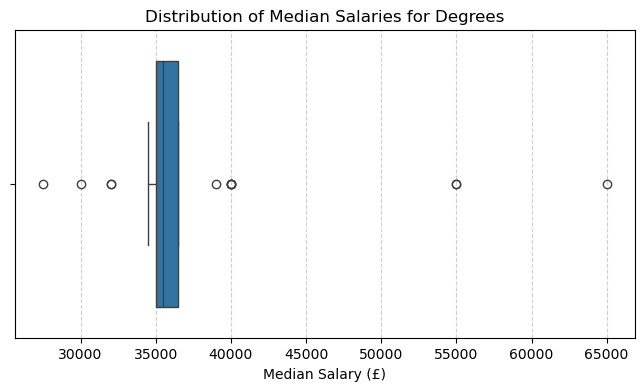

In [58]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=programms_df_clean['median_salary'])
plt.title('Distribution of Median Salaries for Degrees')
plt.xlabel('Median Salary (£)')
plt.grid(axis='x', linestyle='--', alpha=0.6) 
plt.show()

The box plot above clearly depicts that the median 50% of programme graduation salaries are in the range of £35,000-£37,000. Finally, all programmes, apart from 3 outliers, lie within the range of £30,000 to £40,000, meaning that typically there is no great discrepancy.

**3.2.3 Highest/lowest median salary degrees**

Now we look at specificaly which degrees have the highest and lowest median salaries.

In [59]:
top5 = programms_df_clean.nlargest(5, 'median_salary')[['degree', 'median_salary']]\
           .reset_index(drop=True)
bottom5 = programms_df_clean.nsmallest(5, 'median_salary')[['degree', 'median_salary']]\
              .reset_index(drop=True)

top5.columns = ['Top 5 Degrees', 'Top Salaries (£)']
bottom5.columns = ['Bottom 5 Degrees', 'Bottom Salaries (£)']

pd.concat([top5, bottom5], axis=1)

,Top 5 Degrees,Top Salaries (£),Bottom 5 Degrees,Bottom Salaries (£)
0,BSc Finance,65000.0,BSc International Relations,27500.0
1,BSc Econometrics and Mathematical Economics,55000.0,BSc Sociology,30000.0
2,BSc Economics,55000.0,BSc International Social and Public Policy,32000.0
3,BSc Financial Mathematics and Statistics,40000.0,BSc International Social and Public Policy wit...,32000.0
4,BSc Mathematics and Economics,40000.0,BA Anthropology and Law,34500.0


**3.2.4 Is there a relationship between A level requirements and median salaries?**

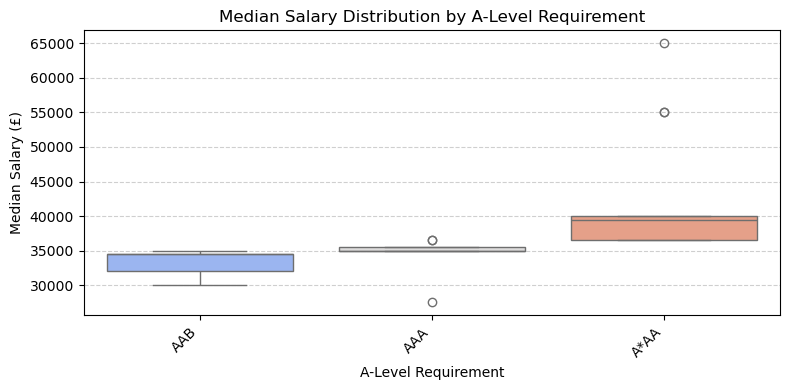

In [60]:
requirement_order = sorted(programms_df_clean['a_lvl_req'].unique(), reverse=True) 
plt.figure(figsize=(8,4))
sns.boxplot(data=programms_df_clean, x='a_lvl_req', y='median_salary', order=requirement_order, palette='coolwarm', hue='a_lvl_req')

plt.title('Median Salary Distribution by A-Level Requirement')
plt.xlabel('A-Level Requirement')
plt.ylabel('Median Salary (£)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

This is one of the most informative graphs in our survey. Median salary seems to be heavily reliant on the A-level requirement of each degree. More specifically, each category of A-level requirement seems to be separated in margins. “AAB” ranges from £30,000 to £35,000; “AAA” ranges from £35,000 to £36,000; and “A*AA” ranges from £37,000 to £40,000. These observations refer to the median 50% of each category.




**3.2.5 What about the relationship between acceptance rates and median salaries?**

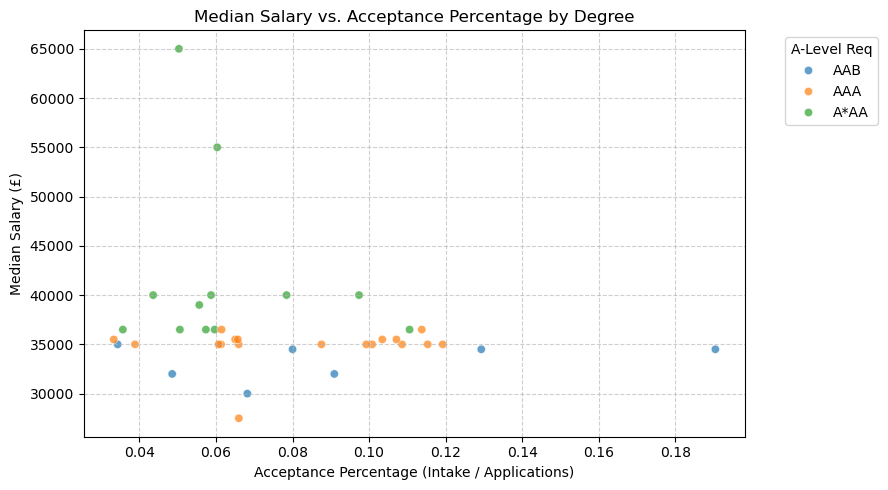

Correlation between Acceptance Percentage and Median Salary: -0.19


In [61]:
plt.figure(figsize=(9,5))
sns.scatterplot(data=programms_df_clean, x='acceptance_perc', y='median_salary', hue='a_lvl_req', alpha=0.7)

plt.title('Median Salary vs. Acceptance Percentage by Degree')
plt.xlabel('Acceptance Percentage (Intake / Applications)')
plt.ylabel('Median Salary (£)')
plt.grid(linestyle='--', alpha=0.6)
plt.legend(title='A-Level Req', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

correlation = programms_df_clean['acceptance_perc'].corr(programms_df_clean['median_salary'])
print(f"Correlation between Acceptance Percentage and Median Salary: {correlation:.2f}")

 It can be seen that there is basically no significant trend between acceptance rates and median salaries and that A*AA degrees are above all other degrees with lower grade requirements.

## 4. Module Data Preperation


* 4.1. _Preparing Module Data Tables_
* 4.2.	_Why did we choose these degrees_
* 4.3.	_The general method employed_
* 4.4.	_Discovering the Designs_
   * 4.41. Finance
   * 4.42. Economics
   * 4.43. International Relations
   * 4.44. Politics and Economics
   * 4.45. Physchological and Behavioural Sciences
* 4.5 _Putting it All Together_

###  4.1 Preparing Module Table and Outside Option Table

*We prepare tables we need for preparing the degree designs, and also begin preparing tables giving us a sense of mark distribution

**4.1.1 Creating Merged Tables** 
* We begin by grouping up the different course code to isolate the data for the summary statistics for each course code. We took the arithmetic mean across the different years for each course code. Finally we duplicated this table and merged with the outside option list we scraped from before to create a table of outside options and their respective scores.

In [62]:
marks_df = pd.read_csv('data/modules/marks_summary_modules.csv')

# We only looked at courses which existed in 23.24
marks_df = marks_df[marks_df['code'].isin(marks_df[marks_df['year'] == '2023/24']['code'].unique())]


summary_df = marks_df.groupby('code').apply(
    lambda group: pd.Series({
        'mean': np.average(group['mean'], weights=group['marks']) if group['marks'].sum() > 0 else np.nan,
        'q10': group['q10'].mean() if group['marks'].sum() > 0 else np.nan,
        'Median': group['median'].mean() if group['marks'].sum() > 0 else np.nan,
        'q90': group['q90'].mean() if group['marks'].sum() > 0 else np.nan,
        'Pooled_SD': (
            np.sqrt(((group['marks'] - 1) * group['sd'] ** 2).sum() / (group['marks'].sum() - len(group)))
            if group['marks'].sum() - len(group) > 0 else np.nan),
        'Department': group['department'].mode()[0] if not group['department'].mode().empty else np.nan
    })).reset_index()

# Merging the DataFrame We Made above with another dataframe to add the units for each course code
module_facts_df = pd.read_csv("data/modules/modul_key_facts_updated.csv")
summary_df = summary_df.merge(module_facts_df[['code', 'units']], on='code', how='left')

# Getting the Marks Distribution of Outside Options
outside_options = pd.read_csv('data/modules/outside_options.csv')
outside_options_marks = outside_options.merge(summary_df,left_on='code',right_on='code',how='left')
outside_options_marks.drop(columns=['course', 'total_students', 'avg_class_size', 'capped'], inplace=True)
outside_options_marks.sort_values(by='mean', ascending=False, inplace=True)
outside_options_marks[["code",'units_x','department','mean','q10','Median','q90','Pooled_SD','prerequisites','mutually_exclusive_courses']].head()


/var/folders/40/ph95_v190tn2r9fxpskjmqhc0000gn/T/ipykernel_20365/2120133131.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_df = marks_df.groupby('code').apply(


,code,units_x,department,mean,q10,Median,q90,Pooled_SD,prerequisites,mutually_exclusive_courses
67,EC336,0.5,Economics,81.200000,71.500,82.500,89.500,8.300000,"['ST102', 'MA100', 'ST109']",[]
69,EC338,0.5,Economics,75.300000,51.200,80.000,91.000,18.600000,"['EC201', 'EC202']",[]
231,LN200,1.0,Language Centre,74.455556,72.525,74.625,75.925,2.844996,['LN100'],[]
252,MA209,0.5,Mathematics,74.407551,55.860,75.100,91.980,14.521311,"['MA203', 'MA212', 'MA103', 'MA102', 'MA100']",[]
38,DS105A,0.5,Data Science Institute,73.800000,62.800,76.000,84.000,9.700000,[],['DS105W']


**4.1.2 Calculating the Mean of The Compulsory Modules**

* We began by defining a very crucial function, which works out the arithmetic mean of all the summary statistics for each of the course codes in any specified list of modules. We then apply this to the list of compulsory modules to test if it works as intended

In [64]:
##AI
def calculate_statistics_for_modules(module_list, summary_df):
    selected_modules = summary_df[summary_df['code'].isin(module_list)]
    weights = selected_modules['units']
    total_weight = weights.sum()

    mean_value = (selected_modules['mean'] * weights).sum() / total_weight
    q10_value = (selected_modules['q10'] * weights).sum() / total_weight
    median_value = (selected_modules['Median'] * weights).sum() / total_weight
    q90_value = (selected_modules['q90'] * weights).sum() / total_weight
    pooled_sd_value = (selected_modules['Pooled_SD'] * weights).sum() / total_weight

    return mean_value, q10_value, median_value, q90_value, pooled_sd_value

programms_df_clean['modules'] = programms_df_clean['modules_y1'] +programms_df_clean['modules_y2'] +programms_df_clean['modules_y3']

programms_df_clean[['Mean', 'Q10', 'Median', 'Q90', 'Pooled_SD']] = programms_df_clean['modules'].apply(
    lambda x: pd.Series(
        calculate_statistics_for_modules(x, summary_df)
        if calculate_statistics_for_modules(x, summary_df) is not None ##AI To Learn How to Use Lambda
        else [np.nan, np.nan, np.nan, np.nan, np.nan],
        index=['Mean', 'Q10', 'Median', 'Q90', 'Pooled_SD']
    ))

programms_df_clean = programms_df_clean.sort_values(by='Mean', ascending=False)
programms_df_clean[["degree","Mean","Median","Q10","Q90","Pooled_SD"]].head()

/var/folders/40/ph95_v190tn2r9fxpskjmqhc0000gn/T/ipykernel_20365/3096819334.py:6: RuntimeWarning: invalid value encountered in scalar divide
  mean_value = (selected_modules['mean'] * weights).sum() / total_weight
/var/folders/40/ph95_v190tn2r9fxpskjmqhc0000gn/T/ipykernel_20365/3096819334.py:7: RuntimeWarning: invalid value encountered in scalar divide
  q10_value = (selected_modules['q10'] * weights).sum() / total_weight
/var/folders/40/ph95_v190tn2r9fxpskjmqhc0000gn/T/ipykernel_20365/3096819334.py:8: RuntimeWarning: invalid value encountered in scalar divide
  median_value = (selected_modules['Median'] * weights).sum() / total_weight
/var/folders/40/ph95_v190tn2r9fxpskjmqhc0000gn/T/ipykernel_20365/3096819334.py:9: RuntimeWarning: invalid value encountered in scalar divide
  q90_value = (selected_modules['q90'] * weights).sum() / total_weight
/var/folders/40/ph95_v190tn2r9fxpskjmqhc0000gn/T/ipykernel_20365/3096819334.py:10: RuntimeWarning: invalid value encountered in scalar divide
  

,degree,Mean,Median,Q10,Q90,Pooled_SD
38,BSc Psychological and Behavioural Science,67.489256,67.813725,61.38451,74.111471,7.108308
9,BSc Economic History and Geography,67.160631,67.875000,58.02000,76.800000,9.195954
22,BSc International Social and Public Policy,66.251064,66.857143,59.00000,73.725714,7.812077
2,BA History,66.174879,67.275000,58.00000,73.542500,8.646911
32,BSc Philosophy Logic and Scientific Method,66.040740,67.995000,56.29200,75.436000,11.273243


**4.1.3 First Year Outside Options** 
* We now filter outside options down to only include 1st year courses in a dataframe we call first year outside options. This is because certain courses have their 1st years choose from a list of 1st year outside options

In [65]:
outside_options_1st_year = outside_options_marks.copy()
outside_options_1st_year['course year'] = outside_options_1st_year['code'].str[2].astype(float)
outside_options_1st_year = outside_options_1st_year[outside_options_1st_year['course year'] == 1.0]
outside_options_1st_year = outside_options_1st_year.dropna(subset=['mean'])
outside_options_1st_year[["code",'units_x','department','mean','q10','Median','q90','Pooled_SD','prerequisites','mutually_exclusive_courses']].head()

,code,units_x,department,mean,q10,Median,q90,Pooled_SD,prerequisites,mutually_exclusive_courses
38,DS105A,0.5,Data Science Institute,73.800000,62.80,76.000000,84.000000,9.700000,[],['DS105W']
0,AC102,0.5,Accounting,71.771288,52.62,74.800000,87.580000,14.904358,[],[]
39,DS105W,0.5,Data Science Institute,70.400000,59.00,73.000000,78.000000,8.000000,[],['DS104A']
347,ST115,0.5,Statistics,70.102410,55.10,70.833333,85.766667,13.730301,"['ST102', 'ST107', 'ST109']",[]
326,SP112,1.0,Social Policy,69.999363,64.08,70.700000,75.640000,5.477388,[],[]


**4.1.4 Module Score Distribution by Department**
* We create a table which groups up modules by department, taking an average of the means and providing a standard deviation figure for the courses in the department. We do this to really understand the distribution of scores between modules in order to spot any trends that may be useful down the line in preparing each degree design. 

In [66]:
department_dist = summary_df.groupby('Department').agg(
    Department_Mean=('mean', 'mean'),
    Department_SD=('mean', 'std')
).reset_index()
department_dist_sorted = department_dist.sort_values(by='Department_SD', ascending=False).reset_index(drop=True)
department_dist_sorted.head()

,Department,Department_Mean,Department_SD
0,Mathematics,63.908494,6.080527
1,Economics,64.044502,5.602156
2,Accounting,64.813868,4.423465
3,Statistics,65.932935,3.984667
4,Management,64.843353,3.071243


### 4.2 Why did we choose these degrees

**4.2.1**   
   * Upon inspection of the different course pages, we quickly discovered how different the pages and courses were from each other. Making one master code which could analyse every single degree to produce a comprenhesive analysis would prove very difficult and prone to error. We hence limited our analysis to 5 degrees, all with certain charateristics which we believe make them interesting degrees to study. By limiting the number of degrees we could really ensure accuracy and that the choices of module that a student can make is very realistic. 
   * Due to every course being different from each other, we try defining functions which are as flexible as possible. This proved to work well. Whenever this broke down however we varied the code to handle these differences for each degree
   * We define an easy degree design as one which has the lowest mean-of means of the modules the student takes, a hard degree design is the highest mean of means of modules the student takes

**4.2.2 The Degrees**

* _Finance_  - Only 2 units of Optionality (Least at LSE)
* _Economics_ - High Graduation Salary, Very Low Acceptance and one of LSE's most Prestigous Courses
* _International Relations_ - 11 Units of Optionality, and lowest Graduation Salary
* _Politics and Economics_ - Most units chosen from the outside options list, and a double award degree
* _Physchological and Behavioural Science_ - highest average amongst it's compulsory modules




### 4.3 General Method Employed

 * Whilst we have scraped all the compulsory courses for each degree possible, we discovered that in some cases there were errors in the list due to the scraping logic not being sophistaced enough to handle the very large differences in course pages. The optional courses were another issue entirely and so we manually created csv files for the degrees we chose to analyse, with the number of units, if its optional/compulsory and the year the module can be taken

* We then prepare each possible combination of module that the student can take and seperate the student into a 'path' based on their 1st year optional module choice.We then use different types of logic, aided by a manual check of the data to ensure compatability to ensure all the optional modules comply with that degree design  of the hardest, easiest and middle values for the mean of means.

* We then add to this one big table with all the degrees to use for further analysis 



### 4.4 Preparing the Degree Designs

### 4.41 Finance

We begin with Finance (our degree), where we look and define most of the functions we will use for the rest of the degrees. 

**4.41.1: Hypothesis**
* As Finance has very little optionality, we hypothesise that the difference between an easy and a hard modules would be limited

**4.41.2: Loading in the Finance Module Options**

In [67]:
finance_options = pd.read_csv("data/degrees/financem.csv")
finance_options.head(5)

,Module,Year,Optional/Compulsory,Prerequisites,Units
0,MA108,1.0,0,0.0,0.5
1,FM100,1.0,0,0.0,0.5
2,FM102,1.0,0,0.0,0.5
3,EC1A3,1.0,0,0.0,0.5
4,EC1B3,1.0,0,0.0,0.5


**4.41.2 Preparing a table with just compulsory modules** 
* We now define a function which looks at all the compulsory modules a student can take ,and create a dataframe which makes a list of modules, the number of units taken and how many more units the student needs to take in first year (that isn't an outside option), marked OO in the Finance Options dataframe

In [68]:
def summarize_compulsory_modules(df, standard_units_per_year=4):
    df['Units'] = pd.to_numeric(df['Units'])
    df['Year'] = pd.to_numeric(df['Year'])
    
    comp = df[df['Optional/Compulsory'] == 0]
    oo = df[df['Module'].str.upper().str.contains('OO')]

    y1_comp = comp[comp['Year'] == 1]['Units'].sum()
    y1_oo = oo[oo['Year'] == 1]['Units'].sum()
    y1_non_oo_needed = standard_units_per_year - y1_comp - y1_oo

    return pd.DataFrame([{
        'Compulsory Modules': comp['Module'].tolist(),'Total Compulsory Units': comp['Units'].sum(),
        'Year 1 Non-OO Units Needed': y1_non_oo_needed}])

initial_combinations_dffi = summarize_compulsory_modules(finance_options)
initial_combinations_dffi

,Compulsory Modules,Total Compulsory Units,Year 1 Non-OO Units Needed
0,"[MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...",10.0,0.5


**4.41.3 Creating 'Paths' for each of the 1st-year optionals** 
* We define a function, which looks for all of the optional modules that aren't an outside option in 1st year to then create the list of modules which are compulsory and then the 1st year optional module the student chose. We decided to segment it like this, because 1st year choices are made before a student properly joins LSE and hence they wouldn't take course difficulty into account as much as their interest in learning that module


In [69]:
from itertools import combinations ##AI to learn about this library

def generate_year1_optional_combinations(base_summary_df, all_modules_df, standard_units_per_year=4):
    needed = base_summary_df.iloc[0]['Year 1 Non-OO Units Needed']
    comp_modules = base_summary_df.iloc[0]['Compulsory Modules']
    comp_units = base_summary_df.iloc[0]['Total Compulsory Units']

    modules = all_modules_df[
        (all_modules_df['Optional/Compulsory'] == 1) & (all_modules_df['Year'] == 1) &  (~all_modules_df['Module'].str.upper().str.contains('OO'))
        ][['Module', 'Units']].dropna().values.tolist()
    
    if not modules:
        return base_summary_df
    
    rows = []
    for r in range(1, len(modules) + 1):
        for combo in combinations(modules, r):
            if sum(u for _, u in combo) == needed:
                opts = [m for m, _ in combo]
                rows.append({
                    'Modules': comp_modules + opts, 'Optional Modules Added': opts, 'Total Units': comp_units + needed})

    return pd.DataFrame(rows)

year1_combos_dffi = generate_year1_optional_combinations(initial_combinations_dffi, finance_options)
year1_combos_dffi2 =year1_combos_dffi
year1_combos_dffi2 

,Modules,Optional Modules Added,Total Units
0,"[MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...",[AC102],10.5
1,"[MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...",[ST101],10.5


**4.41.4 Creating subrows** 
* This function just manipulates the dataframe, so that each optional module choice has a difficulty subrow as is shown below

In [70]:
def create_difficulty_subrows(year1_combos_dfirf):
    subrows = []
    
    for _, row in year1_combos_dfirf.iterrows():
        for difficulty in ['Hard', 'Medium', 'Easy']:
            subrow = row.copy()
            subrow['Difficulty'] = difficulty
            subrows.append(subrow)
    
    year1_combos_dfirf_expanded = pd.DataFrame(subrows)
    
    return year1_combos_dfirf_expanded
year_1_combos_dffi3 = create_difficulty_subrows(year1_combos_dffi2)
year_1_combos_dffi4=year_1_combos_dffi3.copy()
year_1_combos_dffi4

,Modules,Optional Modules Added,Total Units,Difficulty
0,"[MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...",[AC102],10.5,Hard
0,"[MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...",[AC102],10.5,Medium
0,"[MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...",[AC102],10.5,Easy
1,"[MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...",[ST101],10.5,Hard
1,"[MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...",[ST101],10.5,Medium
1,"[MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...",[ST101],10.5,Easy


**4.41.5 Determining the Outside Options the Student Takes**

* We define a function which searches a dataframe list of modules, and attempts to calculate the combination of modules with highest, middle and lowest mean values for a specified number of units. We will then manually check to see if that combination actually works against prerequisites

In [71]:
##ai to learn how to use itertools
def find_mean_of_means_combinationsOO(df, target_units=4.0, code_col='code', mean_col='mean', unit_col='units_x'):
    valid_combos = [
        (", ".join(getattr(c, code_col) for c in combo), np.mean([getattr(c, mean_col) for c in combo]))
        for r in range(1, len(df) + 1)
        for combo in itertools.combinations(df.itertuples(index=False), r)
        if np.isclose(sum(getattr(c, unit_col) for c in combo), target_units)]

    sorted_combos = sorted(valid_combos, key=lambda x: x[1])
    mid_index = len(sorted_combos) // 2

    
    print("Lowest Mean of Means Combo:", sorted_combos[0])
    print("Median Mean of Means Combo:", sorted_combos[mid_index])
    print(" Highest Mean of Means Combo:", sorted_combos[-1])


#find_mean_of_means_combinationsOO(outside_options_marks, target_units=1.5)

**4.41.6 Big Issue** 
* The code above produces a combinations of outside options up to 1.5 units but this took our computers took over an hour to run the code. This was because the number of combinations was in the billions. We realized that the process for finding outside options was going to have to go down a different front for outside options. We can only use this on lists of optional courses where the number of courses is much smaller
* The original plan would be to look at the prerequisites list for each of the outside options the student can take, and then from there work out if that outside option is available to be taken based on the students prior modules. However the section listing prerequisites is incredibly different for every single module and it was impossible for us to come up with a way to extract all information effectively. We settled for adding it as a prerequsite if the course code is mentioned in the prerequisite subheading. However a lot of the prerequisites are mixed with Ands, Or's, or 2 of the 4, and it was very tricky for us to integrate this accurately. So we settled for simply analysing the list of outside options based on mean and choosing modules which are definitely valid and a realistic choice. This was time consuming and removed the automation of our code but we believe we preserved accuracy and hence this was a trade-off we wanted to make.  Furthermore, some outside options have other outside options as prerequisites and the code would then have to be dynamic which would significantly increase the length of code needed. So we defined a function which sorts the means of the outside options mark dataframe and displays a custom number of hard, easy and median mean value modules

In [72]:
def print_sorted_by_mean(dataframe, num=5):
    df = dataframe.dropna(subset=['mean']).sort_values(by='mean')
    print('Hardest'); display(df.iloc[:num][['code', 'mean', 'prerequisites', 'mutually_exclusive_courses','units_x']])
    print('Median'); display(df.iloc[len(df)//2 - num//2 : len(df)//2 + num//2 + (num%2)][['code', 'mean', 'prerequisites', 'mutually_exclusive_courses','units_x']])
    print('Easiest'); display(df.iloc[-num:][['code', 'mean', 'prerequisites', 'mutually_exclusive_courses','units_x']])
##ai to help work out effective median logic

print_sorted_by_mean(outside_options_marks,num=5)

Hardest


,code,mean,prerequisites,mutually_exclusive_courses,units_x
258,MA222,48.790000,['MA100'],[],0.5
246,MA102,50.002740,"['MA108', 'MA100', 'MA107']",['MA103'],0.5
45,EC1B3,51.712965,[],['EC1B5'],0.5
52,EC2C4,53.003552,"['ST102', 'MA107', 'ST107', 'MA100']",['MG205'],0.5
247,MA103,53.980561,"['MA108', 'MA100', 'MA160P']",['MA102'],1.0


Median


,code,mean,prerequisites,mutually_exclusive_courses,units_x
203,LL272,65.661818,[],[],0.5
34,AN393,65.700000,"['AN101', 'AN100', 'AN200']",[],0.5
143,HY206,65.722128,[],[],1.0
24,AN276,65.730435,[],[],0.5
201,LL251,65.765789,[],[],1.0


Easiest


,code,mean,prerequisites,mutually_exclusive_courses,units_x
38,DS105A,73.800000,[],['DS105W'],0.5
252,MA209,74.407551,"['MA203', 'MA212', 'MA103', 'MA102', 'MA100']",[],0.5
231,LN200,74.455556,['LN100'],[],1.0
69,EC338,75.300000,"['EC201', 'EC202']",[],0.5
67,EC336,81.200000,"['ST102', 'MA100', 'ST109']",[],0.5


**4.41.7 Outside Option Selection**

* Upon inspection of the dataframes above, we determined the hardest, easiest and middle outcomes of 1.5 units worth of outside options. We then manually checked this to ensure they were completely valid and then defined a function which would aim to add the dataframe to the one we have already produced above
* We look at the median outcome as well throughout the analysis of degrees to understand what someone who wouldn't pay attention to module difficulty would pick on average. This was done as sanity check of our data to udnerstand the distribution within each degree

In [73]:
def expand_with_difficulty_variants(year1_combos_df, difficulty_df):
    rows = []

    for _, combo in year1_combos_df.iterrows():
        for _, diff in difficulty_df.iterrows():
            if (combo['Difficulty'] == diff['Difficulty'] and 
                combo['Optional Modules Added'] == diff['Optional Modules Added']):
                rows.append({
                    'Modules': combo['Modules'] + diff['OO_added'],
                    'Optional Modules Added': combo['Optional Modules Added'] + diff['OO_added'],
                    'Difficulty': combo['Difficulty'],
                    **{k: combo[k] for k in combo.index if k not in ['Modules', 'Optional Modules Added', 'Difficulty']}
                })

    return pd.DataFrame(rows)

Based on the list of outside options and the students intitial choices, these are the valid outside options the student would take

In [74]:
difficulty_dffi = pd.DataFrame([
    {'Difficulty': 'Hard','Optional Modules Added': ['AC102'],'OO_added': ['MA102', 'AC332', 'EC339']},
    {'Difficulty': 'Medium', 'Optional Modules Added': ['AC102'], 'OO_added': [ 'AC342', 'LL251']}, 
    {'Difficulty': 'Easy',   'Optional Modules Added': ['AC102'], 'OO_added': ['DS105A', 'EH209']},
    {'Difficulty': 'Hard', 'Optional Modules Added': ['ST101'],'OO_added':[ 'MA102', 'LL106']  }, 
    {'Difficulty': 'Medium',  'Optional Modules Added': ['ST101'],  'OO_added': ['AN237', 'LL251'] },
    {'Difficulty': 'Easy', 'Optional Modules Added': ['ST101'], 'OO_added': ['DS105A', 'ST310', 'ST311'] }
])

finance_combos = expand_with_difficulty_variants(year_1_combos_dffi4, difficulty_dffi)
finance_combos


,Modules,Optional Modules Added,Difficulty,Total Units
0,"[MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...","[AC102, MA102, AC332, EC339]",Hard,10.5
1,"[MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...","[AC102, AC342, LL251]",Medium,10.5
2,"[MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...","[AC102, DS105A, EH209]",Easy,10.5
3,"[MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...","[ST101, MA102, LL106]",Hard,10.5
4,"[MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...","[ST101, AN237, LL251]",Medium,10.5
5,"[MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...","[ST101, DS105A, ST310, ST311]",Easy,10.5


**4.41.8 Calculating Statistics for the Modules Chosen**



In [75]:
finance_combos[['Mean', 'Q10', 'Median', 'Q90', 'Pooled_SD']] = finance_combos['Modules'].apply(
    lambda x: pd.Series(calculate_statistics_for_modules(x, summary_df))
)
finance_combos["degree"] = "BSc Finance"
finance_combos[["Modules","Difficulty","Mean","Median","Q10","Q90","Pooled_SD","degree"]]


,Modules,Difficulty,Mean,Median,Q10,Q90,Pooled_SD,degree
0,"[MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...",Hard,62.801920,64.028030,47.036894,78.390379,13.409812,BSc Finance
1,"[MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...",Medium,64.025480,65.062121,49.620303,78.314697,12.186466,BSc Finance
2,"[MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...",Easy,64.854011,65.846212,50.169848,79.218788,12.526142,BSc Finance
3,"[MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...",Hard,62.659597,63.715530,47.388030,77.501515,13.051809,BSc Finance
4,"[MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...",Medium,63.841241,64.807576,49.377576,78.036742,12.394622,BSc Finance
5,"[MA108, FM100, FM102, EC1A3, EC1B3, ST102, FM2...",Easy,64.856697,65.919697,50.004167,79.427652,12.831765,BSc Finance


**4.41.9 The Finance Table**

* We ended up with this table which lists the modules, and the means based on the difficulty the student can choose. If any of the modules do not have any data points, then as they are treated as NaN modules the mean calculation skips them over. 

There are a few interesting obsevrations that can be made here:

* The easiest possible combination for Finance is very similar to the recommended modules that the department suggests to their students.
* It does not appear that there is much of a difference between hard and easy degree designs. We suspect this is because there is very little choice a student can make and hence even if there is a big difference in easy and hard modules it takes up a small % of the overall degree
* We conduct further analysis in the analysis section

Finally, our hypothesis appears to be correct

### 4.42 Economics

**4.42.1 Hypothesis** 
We now analyse Economics, using a lot of the logic we defined above, and a few new functions which fit into the course structure that Economics has. Economics has a high graduation salary, a median amount of optionality and a low acceptance rate. Our hypothesis is that is quite unclear what the difference between easy and hard will be

In [76]:
econ_options = pd.read_csv("data/degrees/econm.csv")

In [77]:
initial_combinations_df3 = summarize_compulsory_modules(econ_options)

In [78]:
year1_combos_df = generate_year1_optional_combinations(initial_combinations_df3, econ_options)

In [79]:
year_1_combos_df2 = create_difficulty_subrows(year1_combos_df)
year_1_combos_df3=year_1_combos_df2.copy()

**4.42.2**
* Economics has an outside options choice in its 1st year. This list is difference to the other outside options list so we pick a module from there for the different designs of the degree.We used the print sorted mean to discover the 1st year outside options.

In [80]:
#print_sorted_by_mean(outside_options_1st_year,num=5)
#This hasn't been shown as the output is very similar to when it was run earlier, and throughout the rest of the report, will never be displayed

In [81]:
difficulty_df = pd.DataFrame([
    {'Difficulty': 'Hard','Optional Modules Added': ['MA100'],'OO_added': ['MA102',"ST101A"]}, 
    {'Difficulty': 'Medium', 'Optional Modules Added': ['MA100'], 'OO_added': ['PH103']}, 
    {'Difficulty': 'Easy', 'Optional Modules Added': ['MA100'],'OO_added': ['DS105A', 'AC102'] }, 
    {'Difficulty': 'Hard', 'Optional Modules Added': ['MA108', 'EC1B1'],'OO_added': ['MA102',"ST101A"] },
    {'Difficulty': 'Medium',  'Optional Modules Added': ['MA108', 'EC1B1'],'OO_added': ['PH103'] },
    {'Difficulty': 'Easy', 'Optional Modules Added': ['MA108', 'EC1B1'], 'OO_added': ['DS105A', 'AC102'] }
])

In [82]:
year_1incOO_df = expand_with_difficulty_variants(year_1_combos_df3, difficulty_df)
year_1incOO_df 

,Modules,Optional Modules Added,Difficulty,Total Units
0,"[EC1P1, EC1A1, ST109, EC1C1, EC2A1, EC2B1, EC2...","[MA100, MA102, ST101A]",Hard,6.0
1,"[EC1P1, EC1A1, ST109, EC1C1, EC2A1, EC2B1, EC2...","[MA100, PH103]",Medium,6.0
2,"[EC1P1, EC1A1, ST109, EC1C1, EC2A1, EC2B1, EC2...","[MA100, DS105A, AC102]",Easy,6.0
3,"[EC1P1, EC1A1, ST109, EC1C1, EC2A1, EC2B1, EC2...","[MA108, EC1B1, MA102, ST101A]",Hard,6.0
4,"[EC1P1, EC1A1, ST109, EC1C1, EC2A1, EC2B1, EC2...","[MA108, EC1B1, PH103]",Medium,6.0
5,"[EC1P1, EC1A1, ST109, EC1C1, EC2A1, EC2B1, EC2...","[MA108, EC1B1, DS105A, AC102]",Easy,6.0


**4.42.2 Completing Optional Course Info**
* we now create code which adds to the options in the course options dataframe, including a lot of the information around means. We then create a table which only looks at the 3rd Year optional courses in Economics (that aren't OO) or courses that dont have any data

In [83]:
def add_summary_and_prereqs(econ_options, summary_df, outside_options_marks):
    merged_df = pd.merge(econ_options, summary_df, left_on='Module', right_on='code', how='left')
    merged_with_outside = pd.merge(merged_df, outside_options_marks[['code', 'prerequisites', 'mutually_exclusive_courses']],
                                   left_on='Module', right_on='code', how='left')

    if 'code' in merged_with_outside.columns:
        merged_with_outside = merged_with_outside.drop(columns=['code'])
    
    return merged_with_outside

merged_df_e = add_summary_and_prereqs(econ_options, summary_df,outside_options_marks)

merged_df_e3= merged_df_e[merged_df_e['Year'] == 3]
merged_df_e3 = merged_df_e3.sort_values(by='mean', ascending=False)
merged_df_e3 = merged_df_e3.dropna(subset=['mean'])
merged_df_e3 = merged_df_e3[~merged_df_e3['Module'].isin(['FM322', 'FM321'])]
merged_df_e3.head()

,Module,Year,Optional/Compulsory,Units,code_x,mean,q10,Median,q90,Pooled_SD,Department,units,code_y,prerequisites,mutually_exclusive_courses
26,EC336,3,1,0.5,EC336,81.200000,71.50,82.5,89.50,8.300000,Economics,0.5,EC336,"['ST102', 'MA100', 'ST109']",[]
28,EC338,3,1,0.5,EC338,75.300000,51.20,80.0,91.00,18.600000,Economics,0.5,EC338,"['EC201', 'EC202']",[]
24,EC334,3,1,0.5,EC334,70.300000,59.80,69.0,80.20,8.200000,Economics,0.5,EC334,"['FM201', 'MA107', 'EC221', 'EC220', 'MA100', ...",[]
13,EC307,3,1,1.0,EC307,69.420201,61.58,70.4,78.60,7.888646,Economics,1.0,EC307,"['ST109', 'MA107', 'EC221', 'ST102', 'EC220', ...",[]
36,PH311,3,1,1.0,PH311,69.136341,61.96,69.4,74.68,7.903559,Method,1.0,PH311,[],[]


In [84]:
def find_mean_of_means_combinations(df, target_units=4.0, code_col='Module', mean_col='mean', unit_col='Units'):
    valid_combos = [
        (", ".join(getattr(c, code_col) for c in combo), np.mean([getattr(c, mean_col) for c in combo]))
        for r in range(1, len(df) + 1)
        for combo in itertools.combinations(df.itertuples(index=False), r)
        if np.isclose(sum(getattr(c, unit_col) for c in combo), target_units)
    ]

    sorted_combos = sorted(valid_combos, key=lambda x: x[1])
    mid_index = len(sorted_combos) // 2

    
    print("Lowest Mean of Means Combo:", sorted_combos[0])
    print("Median Mean of Means Combo:", sorted_combos[mid_index])
    print(" Highest Mean of Means Combo:", sorted_combos[-1])


**4.42.3 Optional Courses Combinations**

In [85]:
find_mean_of_means_combinations(merged_df_e3, target_units=4.0)
#print_sorted_by_mean(outside_options_marks,num=5)


Lowest Mean of Means Combo: ('EC302, EC310, EC337, EC319, EC335', 61.36188861669116)
Median Mean of Means Combo: ('EC338, EC313, EC321, EC311, EC339', 66.7704531590414)
 Highest Mean of Means Combo: ('EC336, EC338, EC307, PH311, EC330', 72.61130832099067)


In [86]:
difficulty_df2 = pd.DataFrame([
    {'Difficulty': 'Hard','Optional Modules Added': ['MA100','MA102',"ST101A"],'OO_added': ['EC302', 'EC310','EC337','EC319','EC335','MA212']}, 
    {'Difficulty': 'Medium', 'Optional Modules Added': ['MA100','PH103'], 'OO_added': ['EC338', 'EC313', 'EC321', 'EC311', 'EC339','HY206']}, 
    {'Difficulty': 'Easy', 'Optional Modules Added': ['MA100','DS105A', 'AC102'],'OO_added': ['EC336', 'EC338', 'EC307', 'PH311', 'EC330','LN200'] }, 
    {'Difficulty': 'Hard', 'Optional Modules Added': ['MA108', 'EC1B1','MA102',"ST101A"],'OO_added': ['EC302', 'EC310','EC337','EC319','EC335','MA212'] },
    {'Difficulty': 'Medium',  'Optional Modules Added': ['MA108', 'EC1B1','PH103'],'OO_added': ['EC338', 'EC313', 'EC321', 'EC311', 'EC339','HY206'] },
    {'Difficulty': 'Easy', 'Optional Modules Added': ['MA108', 'EC1B1','DS105A','AC102'], 'OO_added': ['EC336', 'EC338', 'EC307', 'PH311', 'EC330','LN200'] }
])

year_1incOO_df2 = expand_with_difficulty_variants(year_1incOO_df, difficulty_df2)


In [87]:
year_1incOO_df2[['Mean', 'Q10', 'Median', 'Q90', 'Pooled_SD']] = year_1incOO_df2['Modules'].apply(
    lambda x: pd.Series(
        calculate_statistics_for_modules(x, summary_df)
        if calculate_statistics_for_modules(x, summary_df) is not None
        else [np.nan, np.nan, np.nan, np.nan, np.nan],
        index=['Mean', 'Q10', 'Median', 'Q90', 'Pooled_SD']
    )
)
year_1incOO_df2["degree"] = "BSc Economics"
year_1incOO_df2[["Optional Modules Added","Difficulty","Mean","Median","Q10","Q90","Pooled_SD","degree"]]


,Optional Modules Added,Difficulty,Mean,Median,Q10,Q90,Pooled_SD,degree
0,"[MA100, MA102, ST101A, EC302, EC310, EC337, EC...",Hard,61.230699,62.239236,45.122639,76.860903,13.746595,BSc Economics
1,"[MA100, PH103, EC338, EC313, EC321, EC311, EC3...",Medium,64.422811,65.652778,49.861389,77.718611,12.484491,BSc Economics
2,"[MA100, DS105A, AC102, EC336, EC338, EC307, PH...",Easy,67.349407,68.792361,54.178472,79.444028,11.233336,BSc Economics
3,"[MA108, EC1B1, MA102, ST101A, EC302, EC310, EC...",Hard,61.439569,62.550347,45.526806,76.712292,13.471702,BSc Economics
4,"[MA108, EC1B1, PH103, EC338, EC313, EC321, EC3...",Medium,64.631682,65.963889,50.265556,77.570000,12.209598,BSc Economics
5,"[MA108, EC1B1, DS105A, AC102, EC336, EC338, EC...",Easy,67.558278,69.103472,54.582639,79.295417,10.958443,BSc Economics


**4.42.4 Final Table** 
* On quick inspection there is a much wider difference between easy and hard module here. Potentially because there is a lot more choice. Our hypothesis doesn't really hold here. We suspect this is because there is a lot of hard and easy economics modules. 

### 4.43 International Relations

**4.43.1 Hypothesis**
* International Relations is a degree with a lot of choice, and no outside options and hence we thought it is an interesting degree to analyse. We predict a large range here

In [88]:
ir_options = pd.read_csv("data/degrees/irm.csv")


In [89]:
initial_combinations_dfir = summarize_compulsory_modules(ir_options)


In [90]:
year1_combos_dfir = generate_year1_optional_combinations(initial_combinations_dfir, ir_options)
year_1_combos_dfir2 = create_difficulty_subrows(year1_combos_dfir)                                  
year_1_combos_dfir2                                                                                                                                                        

,Modules,Optional Modules Added,Total Units,Difficulty
0,"[IR100, IR101, LL342, HY113, HY116]","[HY113, HY116]",5.0,Hard
0,"[IR100, IR101, LL342, HY113, HY116]","[HY113, HY116]",5.0,Medium
0,"[IR100, IR101, LL342, HY113, HY116]","[HY113, HY116]",5.0,Easy
1,"[IR100, IR101, LL342, HY113, EH101]","[HY113, EH101]",5.0,Hard
1,"[IR100, IR101, LL342, HY113, EH101]","[HY113, EH101]",5.0,Medium
...,...,...,...,...
26,"[IR100, IR101, LL342, HY116, SO100]","[HY116, SO100]",5.0,Medium
26,"[IR100, IR101, LL342, HY116, SO100]","[HY116, SO100]",5.0,Easy
27,"[IR100, IR101, LL342, PH103, SO100]","[PH103, SO100]",5.0,Hard
27,"[IR100, IR101, LL342, PH103, SO100]","[PH103, SO100]",5.0,Medium


**4.43.2** 
* We manualy remove all the mutually exclusive combinations of 1st year options in IR

In [91]:
year1_combos_dfirf2 = year_1_combos_dfir2[year_1_combos_dfir2['Optional Modules Added'].isin([[ 'HY113', 'HY116' ], [ 'HY113', 'EH101' ],
[ 'HY113', 'GV101' ],[ 'HY113', 'PH103' ],[ 'HY113', 'SO100' ],[ 'HY116', 'EH101' ],[ 'HY116', 'GV101' ],[ 'HY113', 'PH103' ],
['HY113', 'SO10O' ]])]


In [92]:
merged_df_ir = add_summary_and_prereqs(ir_options, summary_df,outside_options_marks)

merged_df_ir3= merged_df_ir[merged_df_ir['Year'] == 3]
merged_df_ir3 = merged_df_ir3.sort_values(by='mean', ascending=False)
merged_df_ir3 = merged_df_ir3.dropna(subset=['mean'])
merged_df_ir3 = merged_df_ir3.dropna(subset=['mean'])
merged_df_ir3 = merged_df_ir3[~merged_df_ir3['Module'].isin(['LL342'])]

merged_df_ir2= merged_df_ir[merged_df_ir['Year'] == 2]
merged_df_ir2 = merged_df_ir2.sort_values(by='mean', ascending=False)
merged_df_ir2 = merged_df_ir2.dropna(subset=['mean'])

result_ir2 = find_mean_of_means_combinations(merged_df_ir2, target_units=4.0)
result_ir3 = find_mean_of_means_combinations(merged_df_ir3, target_units=3.0)


Lowest Mean of Means Combo: ('IR206, IR203, IR205, IR202', 64.99556661137186)
Median Mean of Means Combo: ('IR200, IR206, IR205, IR202', 65.42213910466668)
 Highest Mean of Means Combo: ('IR200, IR206, IR203, IR205', 65.55954716327896)
Lowest Mean of Means Combo: ('IR315, IR380, IR317, IR379, IR368', 64.27927260005377)
Median Mean of Means Combo: ('IR373, IR395, IR398, IR317, IR379', 66.55451921399091)
 Highest Mean of Means Combo: ('IR377, IR373, IR391, IR323, IR398', 68.58705315026954)


In [93]:
append_dict_ir3 = {
    'Hard': ['IR315','IR380','IR317','IR379','IR368','IR206','IR203','IR205','IR202'],
    'Medium': ['IR373','IR395','IR398','IR317','IR379','IR200','IR206','IR205','IR202'],
    'Easy': ['IR377' ,'IR373','IR391','IR323','IR398','IR200','IR206','IR203','IR205']
}

year1_combos_dfirf2.loc[:, 'Modules'] = year1_combos_dfirf2.apply(
    lambda row: list(set(row['Modules'] + append_dict_ir3.get(row['Difficulty'], []))),
    axis=1
)

year1_combos_dfirf2.loc[:, 'Optional Modules Added'] = year1_combos_dfirf2['Difficulty'].apply(
    lambda diff: append_dict_ir3.get(diff, [])
)

In [94]:
year1_combos_dfirf2 = year1_combos_dfirf2.copy() 
year1_combos_dfirf2[['Mean', 'Q10', 'Median', 'Q90', 'Pooled_SD']] = year1_combos_dfirf2['Modules'].apply(
    lambda x: pd.Series(
        calculate_statistics_for_modules(x, summary_df)
        if calculate_statistics_for_modules(x, summary_df) is not None
        else [np.nan] * 5,
        index=['Mean', 'Q10', 'Median', 'Q90', 'Pooled_SD']
    )
)

year1_combos_dfirf2["degree"] = "BSc International Relations"
year1_combos_dfirf2[["Optional Modules Added", "Difficulty", "Mean", "Median", "Q10", "Q90", "Pooled_SD", "degree"]].head()

,Optional Modules Added,Difficulty,Mean,Median,Q10,Q90,Pooled_SD,degree
0,"[IR315, IR380, IR317, IR379, IR368, IR206, IR2...",Hard,64.868774,65.450000,57.547917,72.195417,7.186036,BSc International Relations
0,"[IR373, IR395, IR398, IR317, IR379, IR200, IR2...",Medium,65.561135,65.964583,58.052500,72.786667,6.907933,BSc International Relations
0,"[IR377, IR373, IR391, IR323, IR398, IR200, IR2...",Easy,66.030382,66.283333,58.689167,73.115833,6.516446,BSc International Relations
1,"[IR315, IR380, IR317, IR379, IR368, IR206, IR2...",Hard,64.952634,65.633333,57.641250,72.318750,7.209371,BSc International Relations
1,"[IR373, IR395, IR398, IR317, IR379, IR200, IR2...",Medium,65.644996,66.147917,58.145833,72.910000,6.931268,BSc International Relations


**4.43.3 Final Table**
* Loads of options, but not much of a difference! We suspect this is because even though there is a lot of choice in terms of the absolute number, the degree is choosing from fixed lists which are not much longer than the number of units required

### Politics and Economics

**4.44.1 Hypothesis**
* Particularly after what we found above, we looked for the degree which has the most outside options (there were a lot of ties), so we chose Politics and Economics because it is a dual degree and hence theoretically has access to quite a few different option types. We hypothesise a wide range

In [95]:
pe_options = pd.read_csv("data/degrees/pem.csv")


In [96]:
initial_combinations_dfpe = summarize_compulsory_modules(pe_options)
initial_combinations_dfpe

,Compulsory Modules,Total Compulsory Units,Year 1 Non-OO Units Needed
0,"[GV100, GV101, EC1A3, EC1B3, MA107, ST107, EC2...",6.0,0.0


In [97]:
year1_combos_dfpe = generate_year1_optional_combinations(initial_combinations_dfpe, pe_options)
year1_combos_dfpe2 = create_difficulty_subrows(year1_combos_dfpe)
year1_combos_dfpe2

,Compulsory Modules,Total Compulsory Units,Year 1 Non-OO Units Needed,Difficulty
0,"[GV100, GV101, EC1A3, EC1B3, MA107, ST107, EC2...",6.0,0.0,Hard
0,"[GV100, GV101, EC1A3, EC1B3, MA107, ST107, EC2...",6.0,0.0,Medium
0,"[GV100, GV101, EC1A3, EC1B3, MA107, ST107, EC2...",6.0,0.0,Easy


In [98]:
merged_df_pe = add_summary_and_prereqs(pe_options, summary_df,outside_options_marks)


In [99]:
merged_df_pe2= merged_df_pe[merged_df_pe['Year'] == 2]
merged_df_pe2 = merged_df_pe2.sort_values(by='mean', ascending=False)
merged_df_pe2 = merged_df_pe2.dropna(subset=['mean'])
merged_df_pe2 = merged_df_pe2[merged_df_pe2['Optional/Compulsory'] == 1.0]



merged_df_pe3GV =merged_df_pe[merged_df_pe['Year'] == 3]
merged_df_pe3GV = merged_df_pe3GV[merged_df_pe3GV['Optional/Compulsory'] == 1.0]
merged_df_pe3GV = merged_df_pe3GV.sort_values(by='mean', ascending=False)
merged_df_pe3GV = merged_df_pe3GV.dropna(subset=['mean'])
merged_df_pe3GV = merged_df_pe3GV[merged_df_pe3GV['Module'].str.startswith('GV')]



merged_df_pe3EC =merged_df_pe[merged_df_pe['Year'] == 3]
merged_df_pe3EC = merged_df_pe3EC[merged_df_pe3EC['Optional/Compulsory'] == 1.0]
merged_df_pe3EC = merged_df_pe3EC.sort_values(by='mean', ascending=False)
merged_df_pe3EC = merged_df_pe3EC.dropna(subset=['mean'])
merged_df_pe3EC = merged_df_pe3EC[merged_df_pe3EC['Module'].str.startswith('EC')]


In [100]:
result_pe2 = find_mean_of_means_combinations(merged_df_pe2, target_units=2.0)
result_pe3g = find_mean_of_means_combinations(merged_df_pe3GV, target_units= 1.0)
result_pe3e = find_mean_of_means_combinations(merged_df_pe3EC, target_units=1.0)

Lowest Mean of Means Combo: ('GV248, GV262', 63.50697944297082)
Median Mean of Means Combo: ('GV263, GV251', 65.6675275677614)
 Highest Mean of Means Combo: ('GV249, GV245', 66.86619971391755)
Lowest Mean of Means Combo: ('GV325, GV313', 63.52970690511674)
Median Mean of Means Combo: ('GV328, GV316', 66.65597727272728)
 Highest Mean of Means Combo: ('GV314', 69.475)
Lowest Mean of Means Combo: ('EC339, EC335', 59.15)
Median Mean of Means Combo: ('EC334, EC339', 66.1)
 Highest Mean of Means Combo: ('EC338, EC334', 72.8)


In [101]:
append_dict_pe2 = {
    'Hard': ['GV248','GV262','GV325','GV313','EC339','EC335','LL106','MA102','ST101A'],
    'Medium': ['GV263','GV251','GV328','GV316','EC334','EC339','LL221','LL205'],
    'Easy': ['GV249','GV245','GV314','EC338','EC334','DS105A','AC102','EH209']
}
year1_combos_dfpe3 =year1_combos_dfpe2.copy()
year1_combos_dfpe3['Modules'] = year1_combos_dfpe3.apply(
    lambda row: list(set(row['Compulsory Modules'] + append_dict_pe2.get(row['Difficulty'], []))),
    axis=1
)

year1_combos_dfpe3['Optional Modules Added'] = year1_combos_dfpe3['Difficulty'].apply(
    lambda diff: append_dict_pe2.get(diff, [])
)

In [102]:
year1_combos_dfpe3[['Mean', 'Q10', 'Median', 'Q90', 'Pooled_SD']] = year1_combos_dfpe3['Modules'].apply(
    lambda x: pd.Series(
        calculate_statistics_for_modules(x, summary_df)
        if calculate_statistics_for_modules(x, summary_df) is not None
        else [np.nan, np.nan, np.nan, np.nan, np.nan],
        index=['Mean', 'Q10', 'Median', 'Q90', 'Pooled_SD']
    )
)
year1_combos_dfpe3["degree"] = "BSc Politics and Economics"
year1_combos_dfpe3[["Optional Modules Added","Difficulty","Mean","Median","Q10","Q90","Pooled_SD","degree"]]

,Optional Modules Added,Difficulty,Mean,Median,Q10,Q90,Pooled_SD,degree
0,"[GV248, GV262, GV325, GV313, EC339, EC335, LL1...",Hard,60.956137,62.047569,48.735694,73.435764,12.162210,BSc Politics and Economics
0,"[GV263, GV251, GV328, GV316, EC334, EC339, LL2...",Medium,63.477044,64.319444,53.084444,73.975347,9.601774,BSc Politics and Economics
0,"[GV249, GV245, GV314, EC338, EC334, DS105A, AC...",Easy,65.502960,66.590972,52.948333,76.935833,11.026172,BSc Politics and Economics


**4.44.2 Final Table**
* There does seem to be a little bit more of a range between module choices here, but once again nothing that is realistically too significant. Our hypothesis was wrong here


### 4.45 Psychological and Behavioural Sciences


**4.45.1 Hypothesis** 
* We predict that as PBS is a course which is easy, and has compulsory modules which average out to the highest mean, then potentially the difference between high and low is enough to take the score above 70

In [103]:
pb_options = pd.read_csv("data/degrees/pbsm.csv")
pb_options.head()

,Module,Year,Optional/Compulsory,Units
0,PB101,1,0,1.0
1,PB100,1,0,1.0
2,PB130,1,0,1.0
3,AN100,1,1,1.0
4,GC101,1,1,1.0


In [104]:
initial_combinations_dfpb = summarize_compulsory_modules(pb_options)

In [105]:
year1_combos_dfpb = generate_year1_optional_combinations(initial_combinations_dfpb, pb_options)

In [106]:
year1_combos_dfpb2= create_difficulty_subrows(year1_combos_dfpb) 

In [107]:
merged_df_pb = add_summary_and_prereqs(pb_options, summary_df,outside_options_marks)
merged_df_pb2= merged_df_pb[merged_df_pb['Year'] == 3]
merged_df_pb2 = merged_df_pb2.sort_values(by='mean', ascending=False)
merged_df_pb2 = merged_df_pb2.dropna(subset=['mean'])
merged_df_pb2 = merged_df_pb2[merged_df_pb2['Optional/Compulsory'] == 1.0]
result_pb2 = find_mean_of_means_combinations(merged_df_pb2, target_units=0.5)


Lowest Mean of Means Combo: ('PB307', 63.429166666666674)
Median Mean of Means Combo: ('PB314', 68.72941176470587)
 Highest Mean of Means Combo: ('PB312', 70.7720930232558)


In [108]:
append_dict_pb3 = {
    'Hard': ['AC103','EC1B3','EC1A3','PB307'],
    'Medium': ['LL210','AN237','PB314'],
    'Easy': ['DS105A','EH215','AC102','PB312']
}

year1_combos_dfpb3 =year1_combos_dfpb2.copy()
year1_combos_dfpb3['Modules'] = year1_combos_dfpb3.apply(
    lambda row: list(set(row['Modules'] + append_dict_pb3.get(row['Difficulty'], []))),
    axis=1
)


year1_combos_dfpb3['Optional Modules Added'] = year1_combos_dfpb3['Difficulty'].apply(
    lambda diff: append_dict_pb3.get(diff, [])
)


In [109]:
year1_combos_dfpb3[['Mean', 'Q10', 'Median', 'Q90', 'Pooled_SD']] = year1_combos_dfpb3['Modules'].apply(
    lambda x: pd.Series(
        calculate_statistics_for_modules(x, summary_df)
        if calculate_statistics_for_modules(x, summary_df) is not None
        else [np.nan, np.nan, np.nan, np.nan, np.nan],
        index=['Mean', 'Q10', 'Median', 'Q90', 'Pooled_SD']
    )
)
year1_combos_dfpb3["degree"] = "BSc Psychological and Behavioural Science"
year1_combos_dfpb3[["Optional Modules Added","Difficulty","Mean","Median","Q10","Q90","Pooled_SD","degree"]].head()

,Optional Modules Added,Difficulty,Mean,Median,Q10,Q90,Pooled_SD,degree
0,"[AC103, EC1B3, EC1A3, PB307]",Hard,65.927204,66.448611,58.472083,73.941736,8.568624,BSc Psychological and Behavioural Science
0,"[LL210, AN237, PB314]",Medium,66.971879,67.472222,60.795139,73.752847,7.544002,BSc Psychological and Behavioural Science
0,"[DS105A, EH215, AC102, PB312]",Easy,67.904995,68.480556,60.906528,75.419792,8.121285,BSc Psychological and Behavioural Science
1,"[AC103, EC1B3, EC1A3, PB307]",Hard,66.189799,66.607576,58.624091,74.209167,8.302497,BSc Psychological and Behavioural Science
1,"[LL210, AN237, PB314]",Medium,67.329444,67.724242,61.158333,74.003106,7.184727,BSc Psychological and Behavioural Science


**4.45.2 Final Table** 
* Our hypothesis was wrong here, PBS is also a relatively uninteresting course

### 4.5  Putting it All Together

We add all the tables together, and then select only the hardest and easiest possible combination a student can choose for each degree. 

In [110]:
Final_Comparison = pd.concat([year1_combos_dfpb3,year1_combos_dfpe3,year1_combos_dfirf2,year_1incOO_df2,finance_combos], ignore_index=True)

In [111]:
Final_Comparison = Final_Comparison.loc[[0, 5, 18, 20, 42, 50,54,59,63,65]] 
Final_Comparison[["Difficulty","Mean","Median","Q10","Q90","Pooled_SD","degree"]]

,Difficulty,Mean,Median,Q10,Q90,Pooled_SD,degree
0,Hard,65.927204,66.448611,58.472083,73.941736,8.568624,BSc Psychological and Behavioural Science
5,Easy,68.347389,68.824242,61.279848,75.821591,7.814490,BSc Psychological and Behavioural Science
18,Hard,60.956137,62.047569,48.735694,73.435764,12.162210,BSc Politics and Economics
20,Easy,65.502960,66.590972,52.948333,76.935833,11.026172,BSc Politics and Economics
42,Hard,64.753010,65.375000,57.702917,71.893750,7.273770,BSc International Relations
50,Easy,66.177405,66.583333,59.054167,73.182500,6.912023,BSc International Relations
54,Hard,61.230699,62.239236,45.122639,76.860903,13.746595,BSc Economics
59,Easy,67.558278,69.103472,54.582639,79.295417,10.958443,BSc Economics
63,Hard,62.659597,63.715530,47.388030,77.501515,13.051809,BSc Finance
65,Easy,64.856697,65.919697,50.004167,79.427652,12.831765,BSc Finance


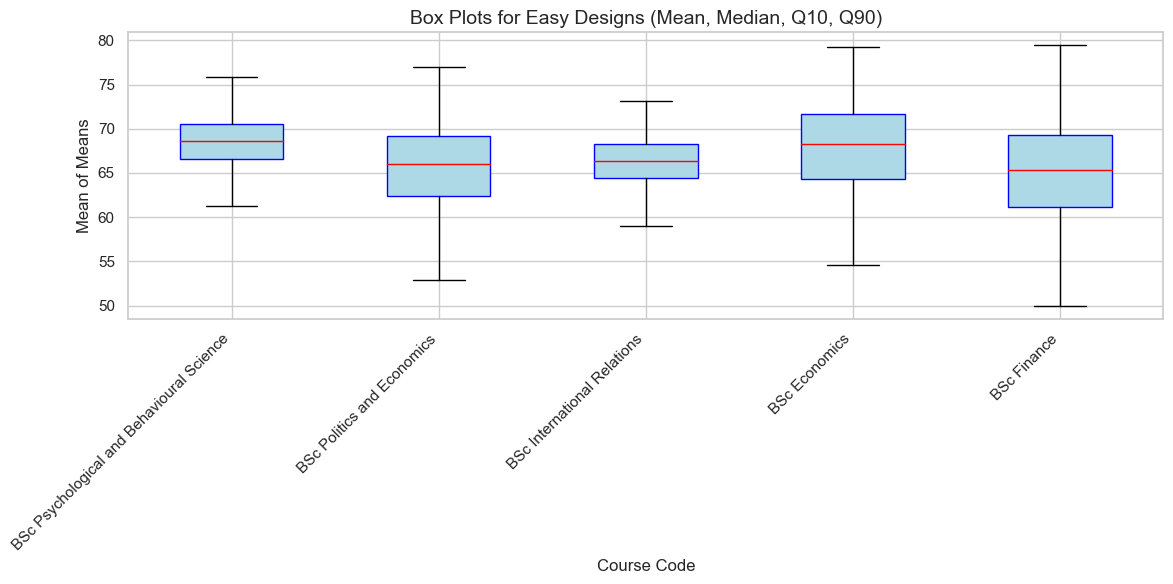

In [198]:
selected_rows = Final_Comparison.iloc[[1, 3, 5, 7, 9]]  # First 5 rows in this case

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
box_data = []
labels = []

for idx, row in selected_rows.iterrows():
    box_data.append([row['Q10'], row['Median'], row['Mean'], row['Q90']])
    labels.append(row['degree'])  


plt.boxplot(box_data, labels=labels, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='black'))

plt.title('Box Plots for Easy Designs (Mean, Median, Q10, Q90)', fontsize=14)
plt.xlabel('Course Code', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.ylabel('Mean of Means', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

* This data is the course distribution for the easy design for degrees. There is a large difference between q10 and q90 in Finance and Economics. This suggests that the students take modules where there isn't as much of a middle ground and the data is more extreme. 

## 5) Module Analysis

**5.1**
* We first want to visualise the discrepancy for hard and easy degree desigsns for the degrees we have chosen to analyse. We put this in reference to thresholds of 70, and 65.5 which are respectively the score required for a first and the overall degree average needed to get a first if you have obtained 8 or more firsts overall

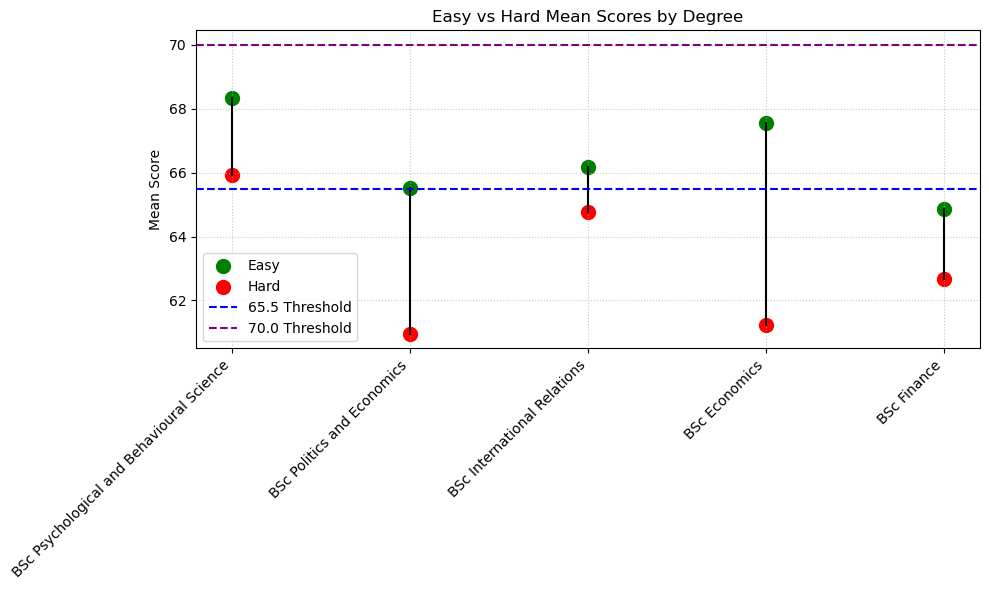

In [112]:
degrees =Final_Comparison["degree"].unique()
easy_means = Final_Comparison[Final_Comparison["Difficulty"] == 'Easy']["Mean"].values
hard_means =  Final_Comparison[Final_Comparison["Difficulty"] == 'Hard']["Mean"].values
fig, ax = plt.subplots(figsize=(10, 6))
for i, degree in enumerate(degrees): ##ai
    ax.plot([i, i], [hard_means[i], easy_means[i]], color='black')  # Line between hard and easy
    ax.scatter(i, easy_means[i], color='green', label='Easy' if i==0 else "", s=100)
    ax.scatter(i, hard_means[i], color='red', label='Hard' if i==0 else "", s=100)
ax.axhline(65.5, color='blue', linestyle='--', label='65.5 Threshold')
ax.axhline(70.0, color='purple', linestyle='--', label='70.0 Threshold')
ax.set_xticks(range(len(degrees)))
ax.set_xticklabels(degrees, rotation=45, ha='right')
ax.set_ylabel('Mean Score')
ax.set_title('Easy vs Hard Mean Scores by Degree')
ax.legend()
ax.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

**5.2**
* We can see here, that for every course except Finance, allows a student to surpass the 65.5 threshold which is a substantial advantage to the student. But no course takes a student above the 70% threshold. There is quite a difference in the ranges between the courses, so we will conduct further analysis to understand what creates these differences.  

* Interestingly, looking at the t-values for each of the course designs, we can see tha conducting a hypothesis test comparing the means between the easy and hard design produces a t value which is below 1, for every single course. There are no degrees of freedom that produce values that low whilst still having a low signifcance level. This indicates that the difference can be purely based on statistical differences of the consitutuent modules and hence there is no likely difference. I.e a student can't really 'cheat the system'.

In [113]:
easy_means = Final_Comparison[Final_Comparison['Difficulty'] == 'Easy'].groupby('degree')['Mean'].mean().reset_index()
easy_means.rename(columns={'Mean': 'Easy_Mean'}, inplace=True)

hard_means = Final_Comparison[Final_Comparison['Difficulty'] == 'Hard'].groupby('degree')['Mean'].mean().reset_index()
hard_means.rename(columns={'Mean': 'Hard_Mean'}, inplace=True)

range_df = pd.merge(easy_means, hard_means, on='degree')

range_df['Range'] = range_df['Easy_Mean'] - range_df['Hard_Mean']

range_df['Primary Department'] = ['Economics', 'Finance', 'Relations', 'Government', 'Science']
range_df
optional_units = programms_df_clean[["degree","total_optional_units",'median_salary','acceptance_perc']]
variance_table = range_df.copy()
var_df = pd.merge(variance_table, department_dist, left_on='Primary Department', right_on='Department', how='left')
opt_df = pd.merge(var_df, optional_units, left_on='degree', right_on='degree', how='left')
opt_df



,degree,Easy_Mean,Hard_Mean,Range,Primary Department,Department,Department_Mean,Department_SD,total_optional_units,median_salary,acceptance_perc
0,BSc Economics,67.558278,61.230699,6.327579,Economics,Economics,64.044502,5.602156,6.0,55000.0,0.06031
1,BSc Finance,64.856697,62.659597,2.197100,Finance,Finance,65.791554,2.202825,2.0,65000.0,0.05031
2,BSc International Relations,66.177405,64.753010,1.424396,Relations,Relations,66.086809,2.225956,10.0,27500.0,0.06596
3,BSc Politics and Economics,65.502960,60.956137,4.546823,Government,Government,66.397081,2.177027,6.0,35500.0,0.06570
4,BSc Psychological and Behavioural Science,68.347389,65.927204,2.420185,Science,Science,67.575514,1.786106,3.5,39000.0,0.05562


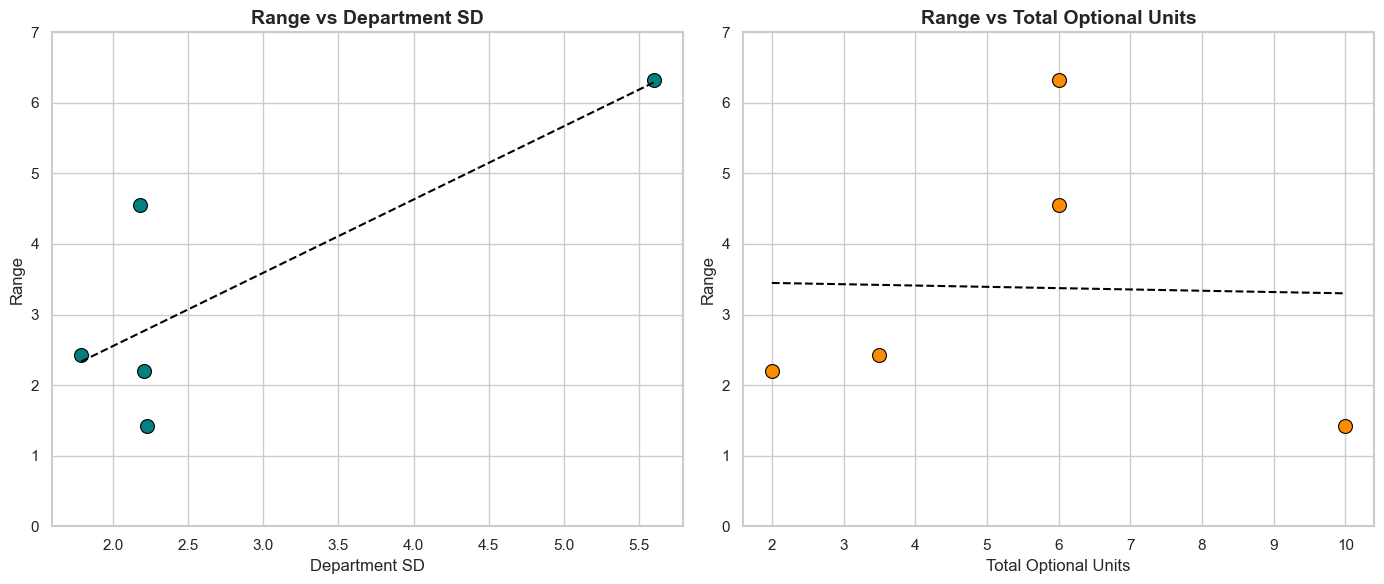

In [114]:
sns.set(style='whitegrid', context='notebook')
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes = axes.flatten()
sns.scatterplot(data=opt_df, x='Department_SD', y='Range', ax=axes[0], color='teal', s=100, edgecolor='black')
x = opt_df['Department_SD']
y = opt_df['Range']
coeffs = np.polyfit(x, y, 1)
x_line = np.linspace(x.min(), x.max(), 100) ##ai to learn how to use a l.o.b.f
y_line = coeffs[0] * x_line + coeffs[1]
axes[0].plot(x_line, y_line, linestyle='--', color='black')

axes[0].set_title('Range vs Department SD', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Department SD', fontsize=12)
axes[0].set_ylabel('Range', fontsize=12)
axes[0].set_ylim(0, 7)
axes[0].tick_params(width=2)
for spine in axes[0].spines.values():
    spine.set_linewidth(1.5)

sns.scatterplot(data=opt_df,x='total_optional_units',y='Range',ax=axes[1],color='darkorange',s=100, edgecolor='black')

x = opt_df['total_optional_units']
y = opt_df['Range']
coeffs = np.polyfit(x, y, 1)
x_line = np.linspace(x.min(), x.max(), 100)
y_line = coeffs[0] * x_line + coeffs[1]
axes[1].plot(x_line, y_line, linestyle='--', color='black')

axes[1].set_title('Range vs Total Optional Units', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Total Optional Units', fontsize=12)
axes[1].set_ylabel('Range', fontsize=12)
axes[1].set_ylim(0, 7)
axes[1].tick_params(width=2)
for spine in axes[1].spines.values():
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

**5.3**
* The first plot analyses how range could be affected by department sd, this is a metric which looks at the difference between the hard and easy modules within the primary department of the course. We looked at this for the reason that because this is a driver between the hard and easy course designs. Certain courses like economics have a lot of variance, and as expected they have a large range. But the overall pattern is unclear. There is an upwards trend but there are lot of courses concentrated around a specific Department SD which makes the trend less obvious. One issue of this is that some courses have options in different department modules, e.g finance which has no option in Finance. 

* The second plot analyses how the range is impacted by the number of optional unis within a degree. This pattern is even more clouded with the regression predicting no pattern. We suspect this is because even though a course may have a large degree of optionality, there are lot of other factors which come into play in explaining the range. One such example may be the number of options the student gets to choose from, (IR has a lot of units of optionality, but overall not many more options to choose from). In a more ideal setting there is a more comprenshive metric of optionality, but the presence of outside options skews the analysis quite significantly.

<Figure size 1000x600 with 0 Axes>

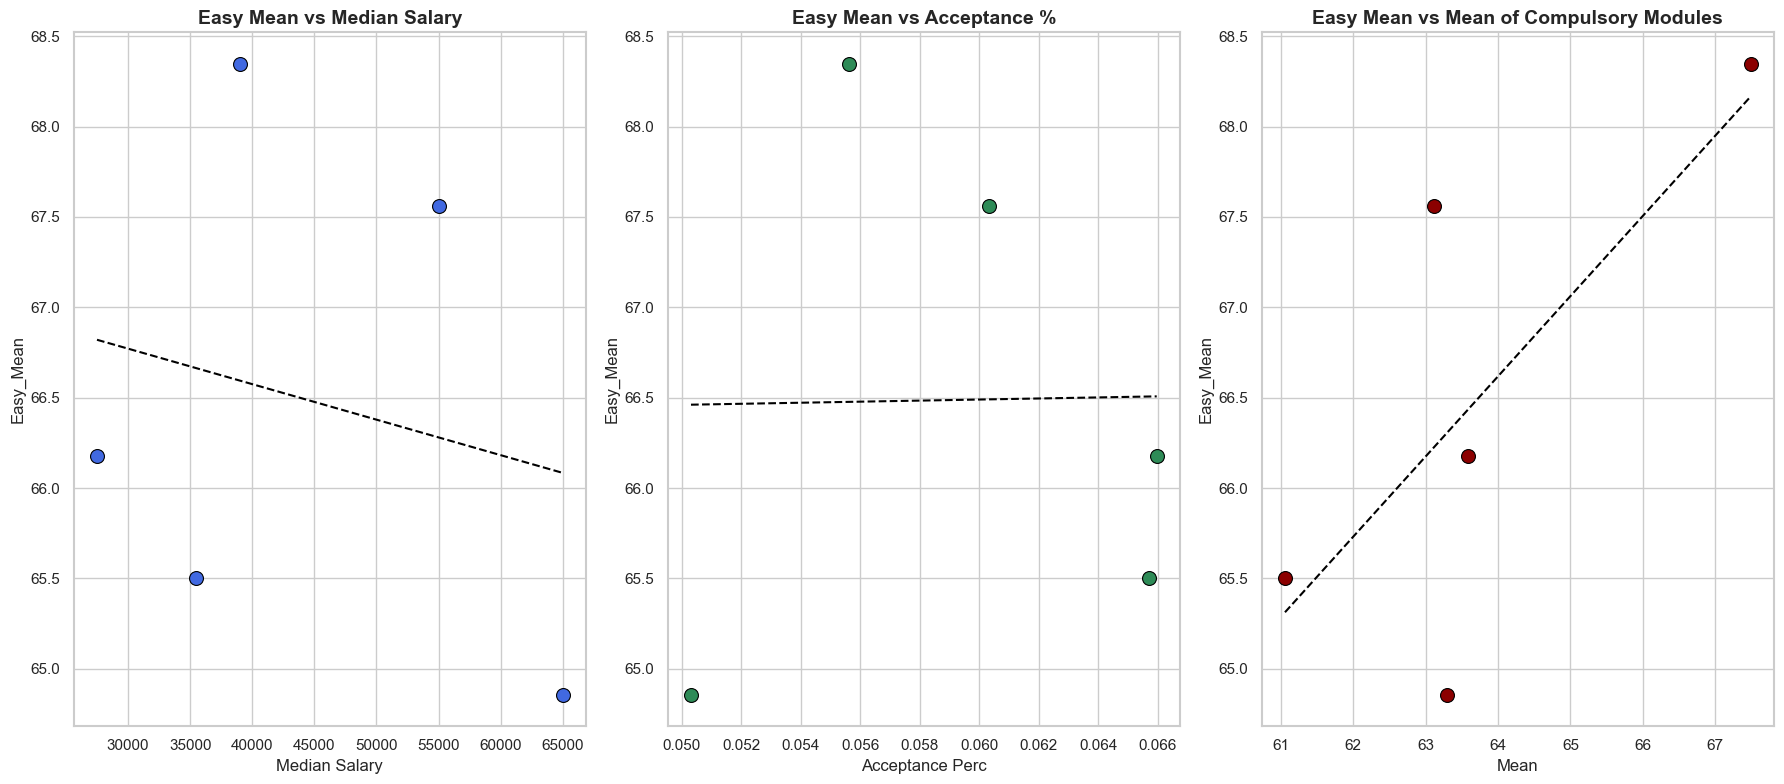

In [115]:
baseline_dif= programms_df_clean[['degree','Mean']]
diff_df = pd.merge(opt_df.copy(), baseline_dif, left_on='degree', right_on='degree', how='left')
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid', context='notebook')

fig, axes = plt.subplots(1, 3, figsize=(18, 8))
axes = axes.flatten()

x_vars = ['median_salary', 'acceptance_perc', 'Mean']
titles = ['Easy Mean vs Median Salary', 'Easy Mean vs Acceptance %', 'Easy Mean vs Mean of Compulsory Modules']
colors = ['royalblue', 'seagreen', 'darkred']

for i, x_var in enumerate(x_vars):
    ax = axes[i]
    
    sns.scatterplot(data=diff_df,x=x_var,y='Easy_Mean',ax=ax,color=colors[i],s=100,edgecolor='black')
    x = diff_df[x_var]
    y = diff_df['Easy_Mean']
    coeffs = np.polyfit(x, y, 1)
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = coeffs[0] * x_line + coeffs[1]
    ax.plot(x_line, y_line, linestyle='--', color='black')
    ax.set_title(titles[i], fontsize=14, fontweight='bold')
    ax.set_xlabel(x_var.replace('_', ' ').title(), fontsize=12)
    ax.set_ylabel('Easy_Mean', fontsize=12)
    ax.tick_params(width=2)
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

**5.4**

* Range between hard and easy is something that is impacted by some other factors, but we also want to analyse how difficult a course is, based on certain factors and how this correlates with outcomes. I.e can you pick an easy degree and unlock good enough outcomes. 

* The first plot shows that as a course gets harder, the median salary by graduates (after 15 months) gets higher. This is relatively in line with what is expected. With there being so few data points the actual relationship is hard to confirm. As Economics has a relatively easy design and a high grad salary so we will not make an asssertive statement here.
* The second plot shows that acceptance rate has no relationship with how easy a course is. This is possibly because there are so many other factors driving acceptance %, and prospective students do not have an idea of how easy a course is until they get to LSE. The factor we would attribute to this would be 'prestige'. This 'prestige' is a factor in our opinion driven by acceptance rate, grad salary and how difficult a course is. But this is a very hard factor to isolate and measure
* The third plot is a definitive relationship that as the compulsory courses get easier, the highest mean outcome for the easy design increases. This is an expected driver

**5.5 Hardest and Easiest Modules**
* Something we have noticed is that there are a lot of similar outside options, which have no prerequisites, that regularly come up in a lot of the different course designs. We analyse the 5 hardest and 5 easiest modules.

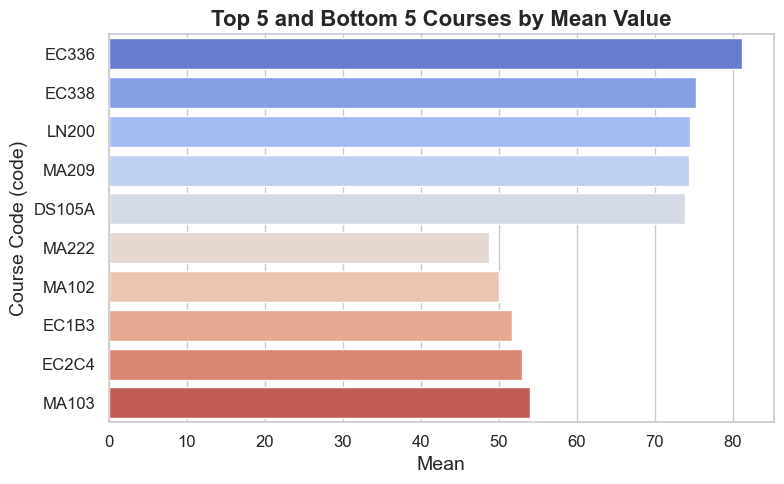

In [197]:
top_5 = outside_options_marks.nlargest(5, 'mean')
bottom_5 = outside_options_marks.nsmallest(5, 'mean')
top_bottom_df = pd.concat([top_5, bottom_5])
plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")
sns.barplot(x='mean', y='code', data=top_bottom_df, palette='coolwarm')
plt.title('Top 5 and Bottom 5 Courses by Mean Value', fontsize=16, fontweight='bold')
plt.xlabel('Mean', fontsize=14)
plt.ylabel('Course Code (code)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

* The chart above shows how that almost all the hardest, and easiest modules are from Maths and Economics Departments. Furthermore, when we manually entered all the optionals we noticed that we were regularly typing in similar modules. This chart above proves our suspicion* The chart above shows how that almost all the hardest, and easiest modules are from Maths and Economics Departments. Furthermore, when we manually entered all the optionals we noticed that we were regularly typing in similar modules. This chart above proves our suspicion

### Conclusion

#### Summary of Findings

* Based on the analysis we have done above, we do not believe it is possible to 'game' the system and choose easy modules to increase your overall degree score. This is due to statistical variation in the course results, assuming that the student is as good as the average. Even despite the statistical variation, the largest range is only 6% and is only ever enough to push a student above the 1st threshold to obtain a first. Additionally, this range is very dependent on the % of courses in specific departments as some departments have a large range of hard and easy courses. In terms of graduate outcome, it is unclear whether an easy degree really correlates with higher grad salary and the difficulty of joining a course has little to do with how easy a course is. Overall selecting a 'percieved easy degree to get into' does not mean that it is an easy course and hence a degree with higher salary. Overall LSE has a relatively robust degree system that is well designed and fair.  

* Some courses have given recommendations which are actually the easiest possible combination that a student can take, such as BSc Finance. The mean outcome is always in the 2:1 classification, q10 is never a fail and q90 is always a first, regardless of difficulty. The hardest modules at LSE are Maths and Economics. We have also found that the A- Level requirement for a course is actually well correlated with graduate salary. Most degrees have graduate salary between a thin band apart from a few outliers. 

#### Limitiations

As discussed, there are quite a lot of limitations in our analaysis. A lot of these have mentioned beforehand but we will run through a quick summary of the limitations and how they impacted the analysis

* **Only Choosing 5 Degrees** - This was done due to the difficulty of completing an accurate and comprehensive study of the degrees at LSE. We have chose different specific charateristics here which would be a reason for having a large difference between hard and easy.
* **Missing Courses** - Some courses have no data as they didnt exist in the last year. Therefore the calcualtion for mean has simply skipped it over
* **Students may have correlated performance** - we have made an assumption in our t testing, that the student is average at every module, but if they are good at some courses they are likely to be good at others which impacts the standard error for each course.
* **Manual Selection**  - We have had to lose a degree of automation, but we have prioritised accuracy of our analysis.
* **Lack of Degree Classification** - We have had to build up the modules list for each degree but we don't have a frame of reference to ensure accuracy

#### What else could be done?

The natural next step would be to analyse the rest of the degrees at LSE, and adapting our code to be able to process course combinations fully automatically, this would involve creating a significantly more intelligent scraping bot. With all of this we can comprenhesively compare different charateristics to make a more informed decision

**References**

* We have declared our usage of AI on the word plagiarism document.
* All other data sources have came from LSE Webpages